### Customer Lifetime Prediction Using Probabilistic Models 
### Midway Report

In [238]:
#importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [239]:
df = pd.read_excel(
    "/Users/sousekilyu/Downloads/online_retail_II.xlsx",
    sheet_name=["Year 2009-2010", "Year 2010-2011"],
) #reading the excel file

In [240]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [241]:
df1.shape, df2.shape #checking for the shape of data

((525461, 8), (541910, 8))

In [242]:
sum([df1.shape[0], df2.shape[0]])

1067371

In [243]:
data = pd.concat([df1, df2], axis=0)

In [244]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [245]:
data.shape

(1067371, 8)

In [246]:
data.isnull().sum()/data.shape[0]*100 #checking for the null values

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.766873
Country         0.000000
dtype: float64

In [247]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [248]:
data.isnull().sum() #Now let's check the data before droping these customer ID's

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    238625
Country             0
dtype: int64

In [249]:
data[data["Customer ID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [250]:
data.iloc[575:, :]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
576,C489524,21258,VICTORIAN SEWING BOX LARGE,-1,2009-12-01 11:48:00,12.75,15614.0,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
579,489526,85049E,SCANDINAVIAN REDS RIBBONS,12,2009-12-01 11:50:00,1.25,12533.0,Germany
580,489526,21976,PACK OF 60 MUSHROOM CAKE CASES,24,2009-12-01 11:50:00,0.55,12533.0,Germany
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [251]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value

data.dropna(axis = 0, subset = ["Customer ID"], inplace = True)

In [252]:
data.isnull().sum() #Now's there is no null values available in our data

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [253]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [254]:
temp_df = pd.DataFrame(data["Country"].value_counts()) #creating the temporary data frame

In [255]:
temp_df.head(10)

,count
Country,
United Kingdom,741301
Germany,17624
EIRE,16195
France,14202
Netherlands,5140
Spain,3811
Belgium,3123
Switzerland,3064
Portugal,2504


In [256]:
names  = temp_df.index

In [257]:
plot_df = temp_df.reset_index()
px.bar(
    plot_df,
    x="count",
    y="Country",
    orientation="h",
    title="Country Occurrence in Dataset",
)

As you can see the **United Kingdom** has the max transcations as compared to other countries. The one here to note is that the **"United Kingdom"** is the dominating class in this data which making our data looks kinda imbalanced between major class and the minority class. 

You can cross check the same after de-selecting the **United Kingdom** from the above chart and see how your axis transforms.

In [258]:
#Now let's check the total quantity and by country
data.groupby("Country")["Quantity"].sum().sort_values(ascending=False).head(10)
# data.groupby("Country")["Quantity"].sum().sort_values(ascending=False).tail(10)


Country
United Kingdom    8353502
Netherlands        381951
EIRE               313373
Denmark            235218
Germany            224581
France             183339
Australia          103706
Sweden              87737
Switzerland         51831
Spain               45156
Name: Quantity, dtype: int64

In [259]:
#checking for the average price by country

px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)

From the above dot plot we can conclude that the **Singapore** has the highest averge price followed by the **Norway** and **Malta**. Let's go deeper and see the distribution to better understand about our data.

In [260]:
countries = data["Country"].unique() #extracting unique country names

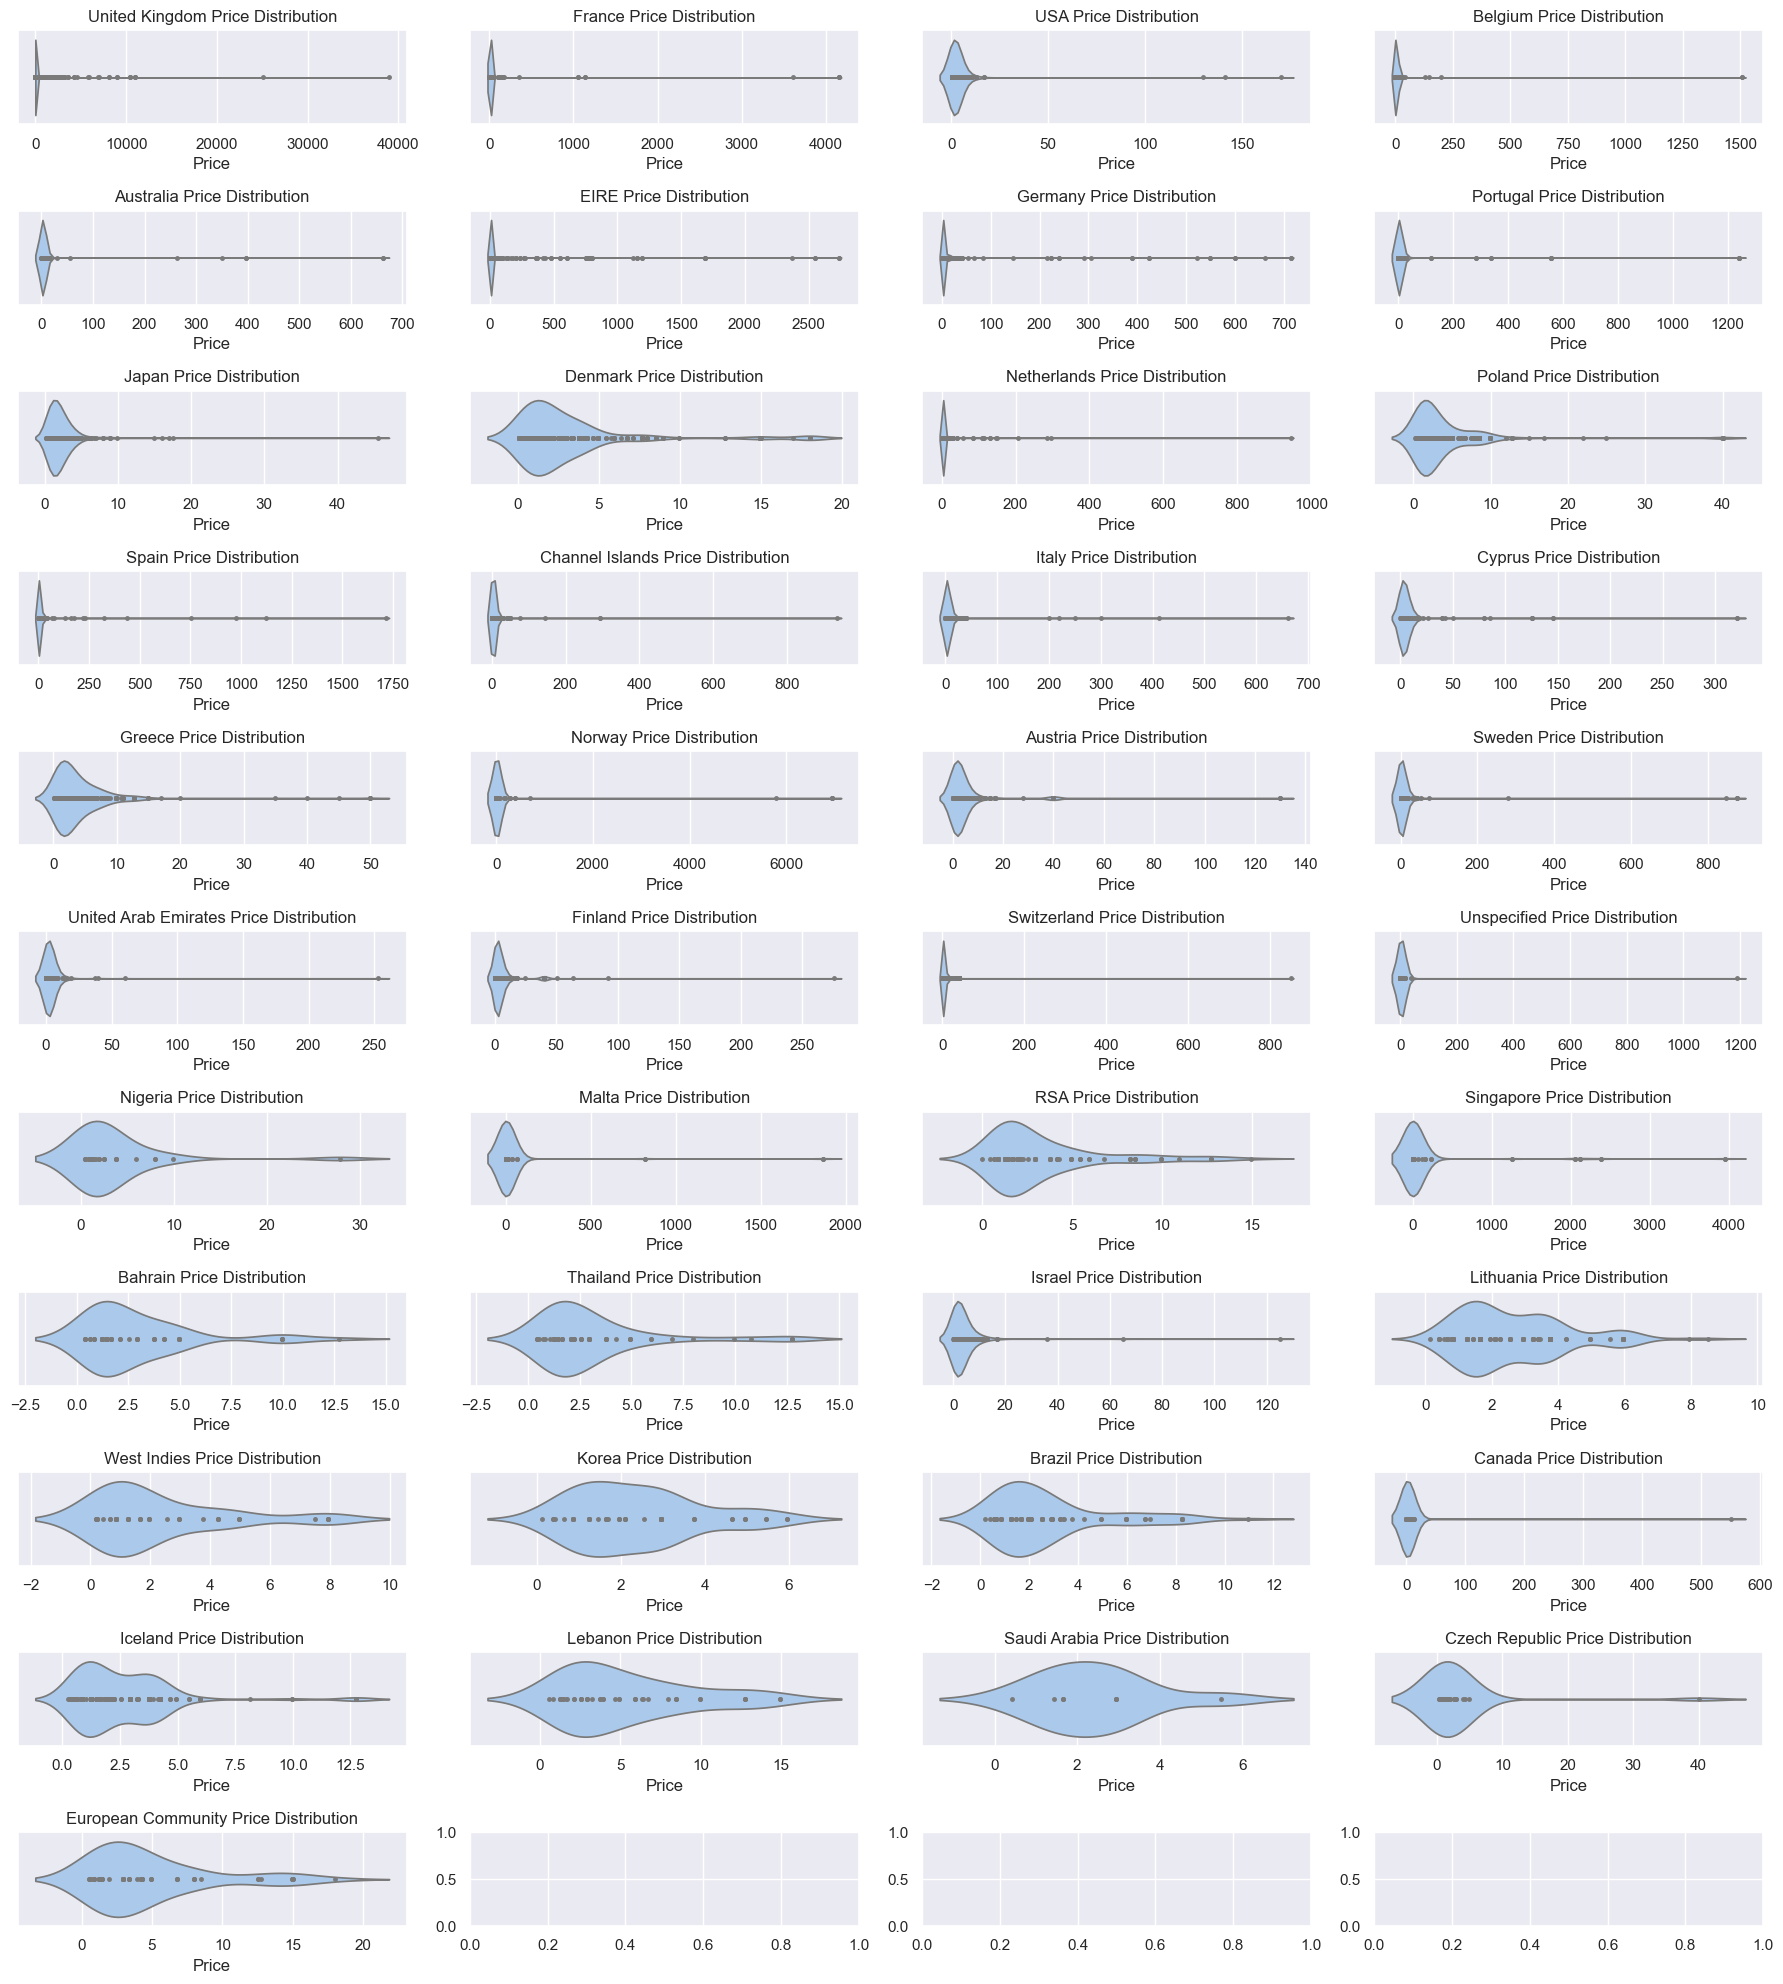

In [261]:
#plotting the violin plot for the data
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [262]:
#Total Number of Unique Invoices 
len(data["Invoice"].unique())

44876

In [263]:
temp_invoice_df = data.groupby("Invoice").sum(numeric_only=True)

In [264]:
temp_invoice_df.reset_index(inplace = True)

In [265]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

,Invoice,Quantity
11080,518505,87167
13425,524174,87167
3064,497946,83774
36942,581483,80995
20348,541431,74215
4379,501534,63974
2096,495194,63302
4693,502269,40000
1604,493819,25018
1047,491812,20524


In [266]:
# convert Price to numeric (coerce invalid values to NaN), then compute mean Price per Invoice and get top 15
data["Price"] = pd.to_numeric(data["Price"], errors="coerce")

top15 = (
    data.groupby("Invoice", as_index=False)["Price"]
    .mean()
    .sort_values("Price", ascending=False)
    .head(15)
)

top15


,Invoice,Price
42923,C556445,38970.00
39136,C512770,25111.09
38141,C502264,10953.50
4689,502263,10953.50
38140,C502262,10953.50
13417,524159,10468.80
40016,C522793,10468.80
40254,C525398,10468.80
37621,C496116,8985.60
2444,496115,8985.60


I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number **489444** & **489447** has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [267]:
data[(data["Invoice"] == "C556445") | (data["Invoice"] == "C512770")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom


As you can see above, These 2 invoices with invoice number **489444** and **489447** had only single transaction, that's why the average price was too high.

### **INITIAL EDA INSIGHTS:**

1) Most of the customers are from the United Kingdom followed by the Germany, EIRE & France.

2) If we check the average price sale by countries, what we have observed is that Singapore has the highest averge price sale followed by the Norway and Malta.

3) Most of the countries data is skewed when it comes to the Price feature with lots of higher extreme values.

4) There are total 44876 uniques purchased happend so far.

5) We have also observed some of the Invoices who have purchased most of the quantities within 2 year of span.

6) When it comes to the average spend there are 2 invoices with number 489444 and 489447 having the highest average spent but upon inspection we also found the average product purchase was only 1 which is from USA followed by Belgium.

In [268]:
#Let's look at the data once again & see what else insights we can get from the data itself
data.head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


### **Exploratory Data Analysis Continued.....**



<Axes: xlabel='Description'>

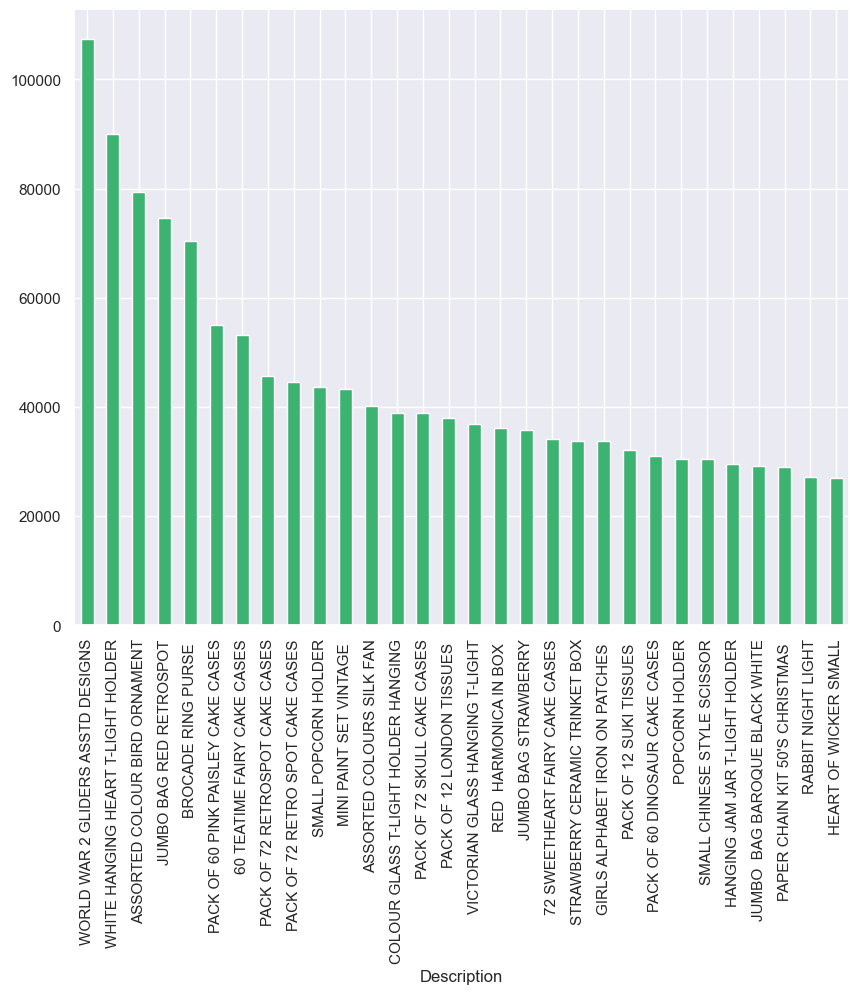

In [269]:
#Let's check which product has been purchased more often so far
# ensure Quantity is numeric to avoid int+str during groupby.sum
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce').fillna(0).astype(int)

plt.figure(figsize=(10,8))
(data.groupby('Description')['Quantity']
     .sum()
     .sort_values(ascending=False)
     .head(30)
     .plot(kind='bar', color='mediumseagreen')
)

In [270]:
temp_data = data.copy() #creating a data copy point

In [271]:
temp_data #use the temp data for adding some extra columns to the data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [272]:
#Date Time Analysis
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek

In [273]:
#Mapping day of week
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [274]:
#renaming the data values using map function
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [275]:
temp_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Time,Year,Day,Quarter,Day of Week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12,12:50:00,2011,9,4,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,12,12:50:00,2011,9,4,Friday


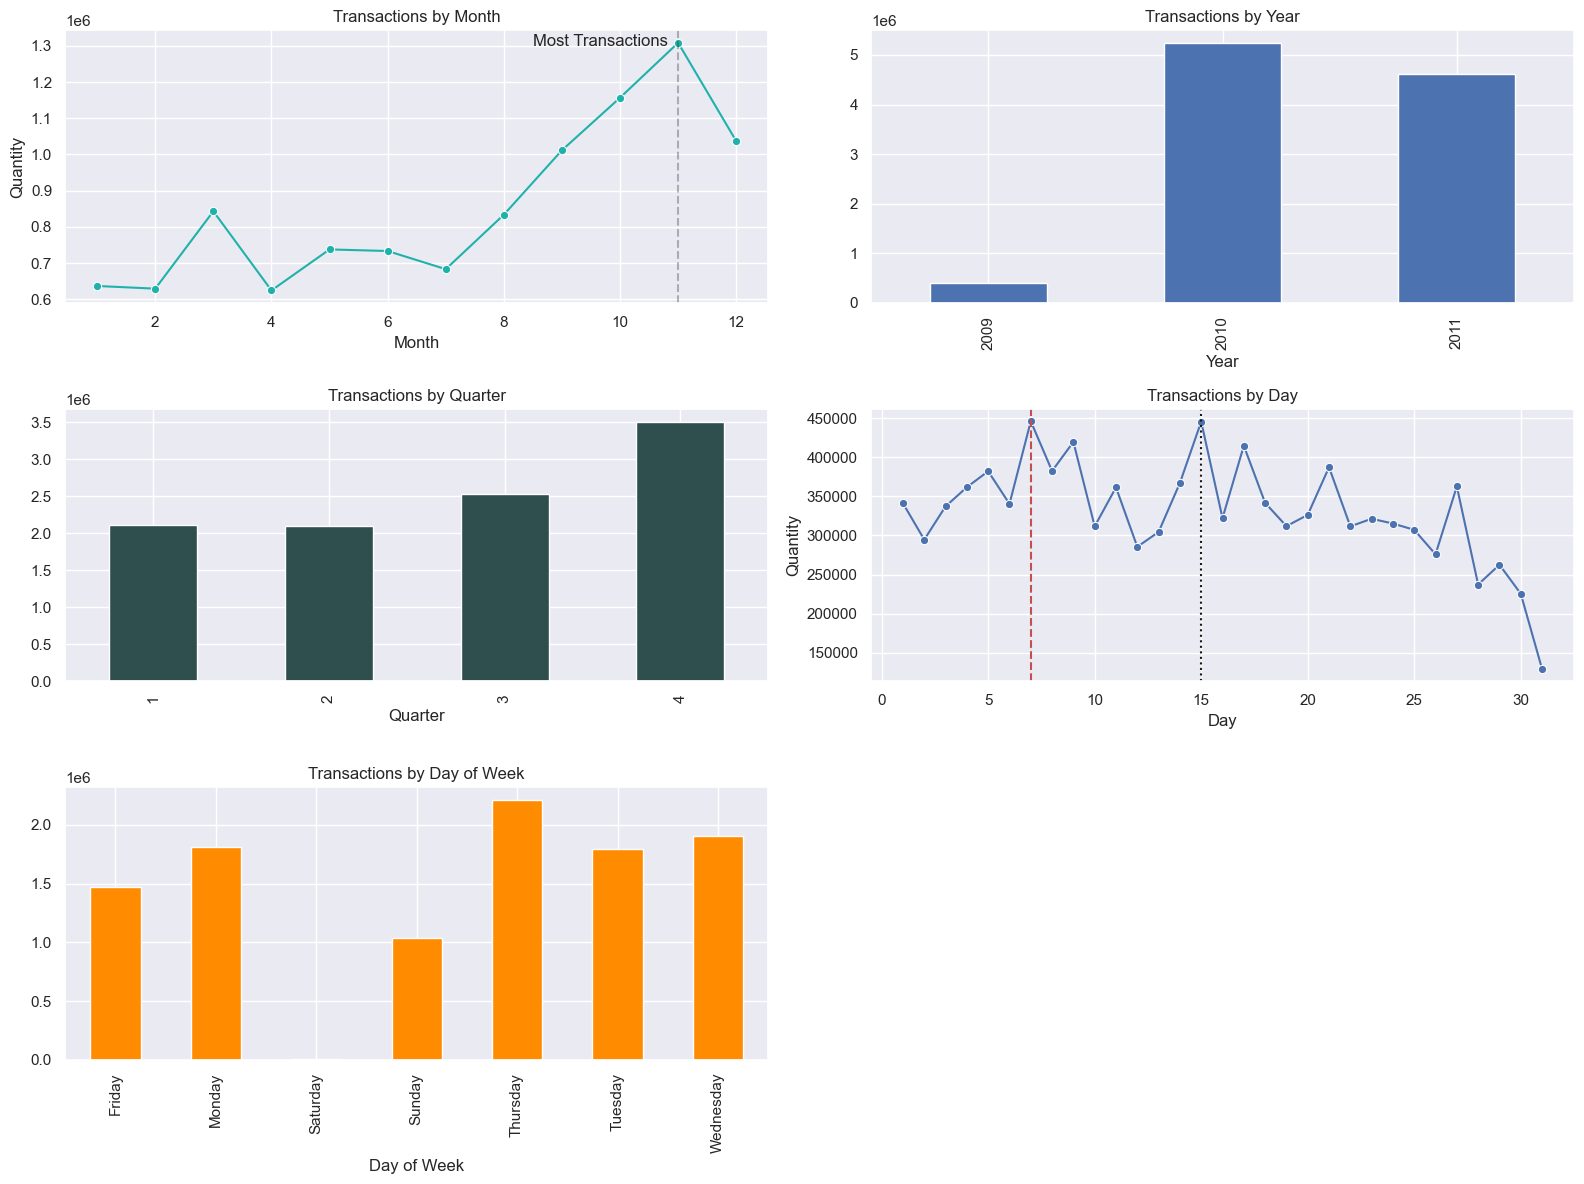

In [ ]:
# Plotting the above data
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
month_qty = temp_data.groupby("Month")["Quantity"].sum().reset_index()
sns.lineplot(x="Month", y="Quantity", data=month_qty, marker="o", color="lightseagreen")
plt.axvline(11, color="k", linestyle="--", alpha=0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")

plt.subplot(3, 2, 2)
year_qty = temp_data.groupby("Year")["Quantity"].sum()
year_qty.plot(kind="bar")
plt.title("Transactions by Year")

plt.subplot(3, 2, 3)
quarter_qty = temp_data.groupby("Quarter")["Quantity"].sum()
quarter_qty.plot(kind="bar", color="darkslategrey")
plt.title("Transactions by Quarter")

plt.subplot(3, 2, 4)
day_qty = temp_data.groupby("Day")["Quantity"].sum().reset_index()
sns.lineplot(x="Day", y="Quantity", data=day_qty, marker="o")
plt.axvline(7, color="r", linestyle="--")
plt.axvline(15, color="k", linestyle="dotted")
plt.title("Transactions by Day")

plt.subplot(3, 2, 5)
dow_qty = temp_data.groupby("Day of Week")["Quantity"].sum()
dow_qty.plot(kind="bar", color="darkorange")
plt.title("Transactions by Day of Week")

plt.tight_layout()
plt.show()

As we can see, in 2009 the transactions is quite low as compared to 2010 and 2011. But as if now, we don't know the reason behind this so let's investigate why 2009 is low as compared to other 2 years.

In [277]:
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2009]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2009]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2010]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2010]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2011]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2011]["Quantity"].sum()))

Total Number of Countries in 2009: 23
Total Number of Transactions in 2009: 390286
--------------------------------------------
Total Number of Countries in 2009: 37
Total Number of Transactions in 2009: 5233315
--------------------------------------------
Total Number of Countries in 2009: 36
Total Number of Transactions in 2009: 4610527


Through this analysis what conclusion we can make is that may be the company has started their operations in other countries and started to expand their business further.

In [278]:
_2009 = temp_data[temp_data["Year"] == 2009]["Country"].unique()
_2010 = temp_data[temp_data["Year"] == 2010]["Country"].unique()
_2011 = temp_data[temp_data["Year"] == 2011]["Country"].unique()

In [279]:
#checking for the countries which are available in  2010 and 2011 but not in 2009.

no_cols = []

for i in (_2010):
    if i not in _2009:
        no_cols.append(i)
print("These are the values which are not present in 2009: {}".format(no_cols))

These are the values which are not present in 2009: ['Unspecified', 'Nigeria', 'Malta', 'RSA', 'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland']


In [280]:
temp = (data.assign(Quantity=pd.to_numeric(data['Quantity'], errors='coerce'))
            .groupby(['Country', 'Description'])['Quantity']
            .sum())

In [281]:
temp = pd.DataFrame(temp)

### Top 8 Countries With Popular Products

In [282]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

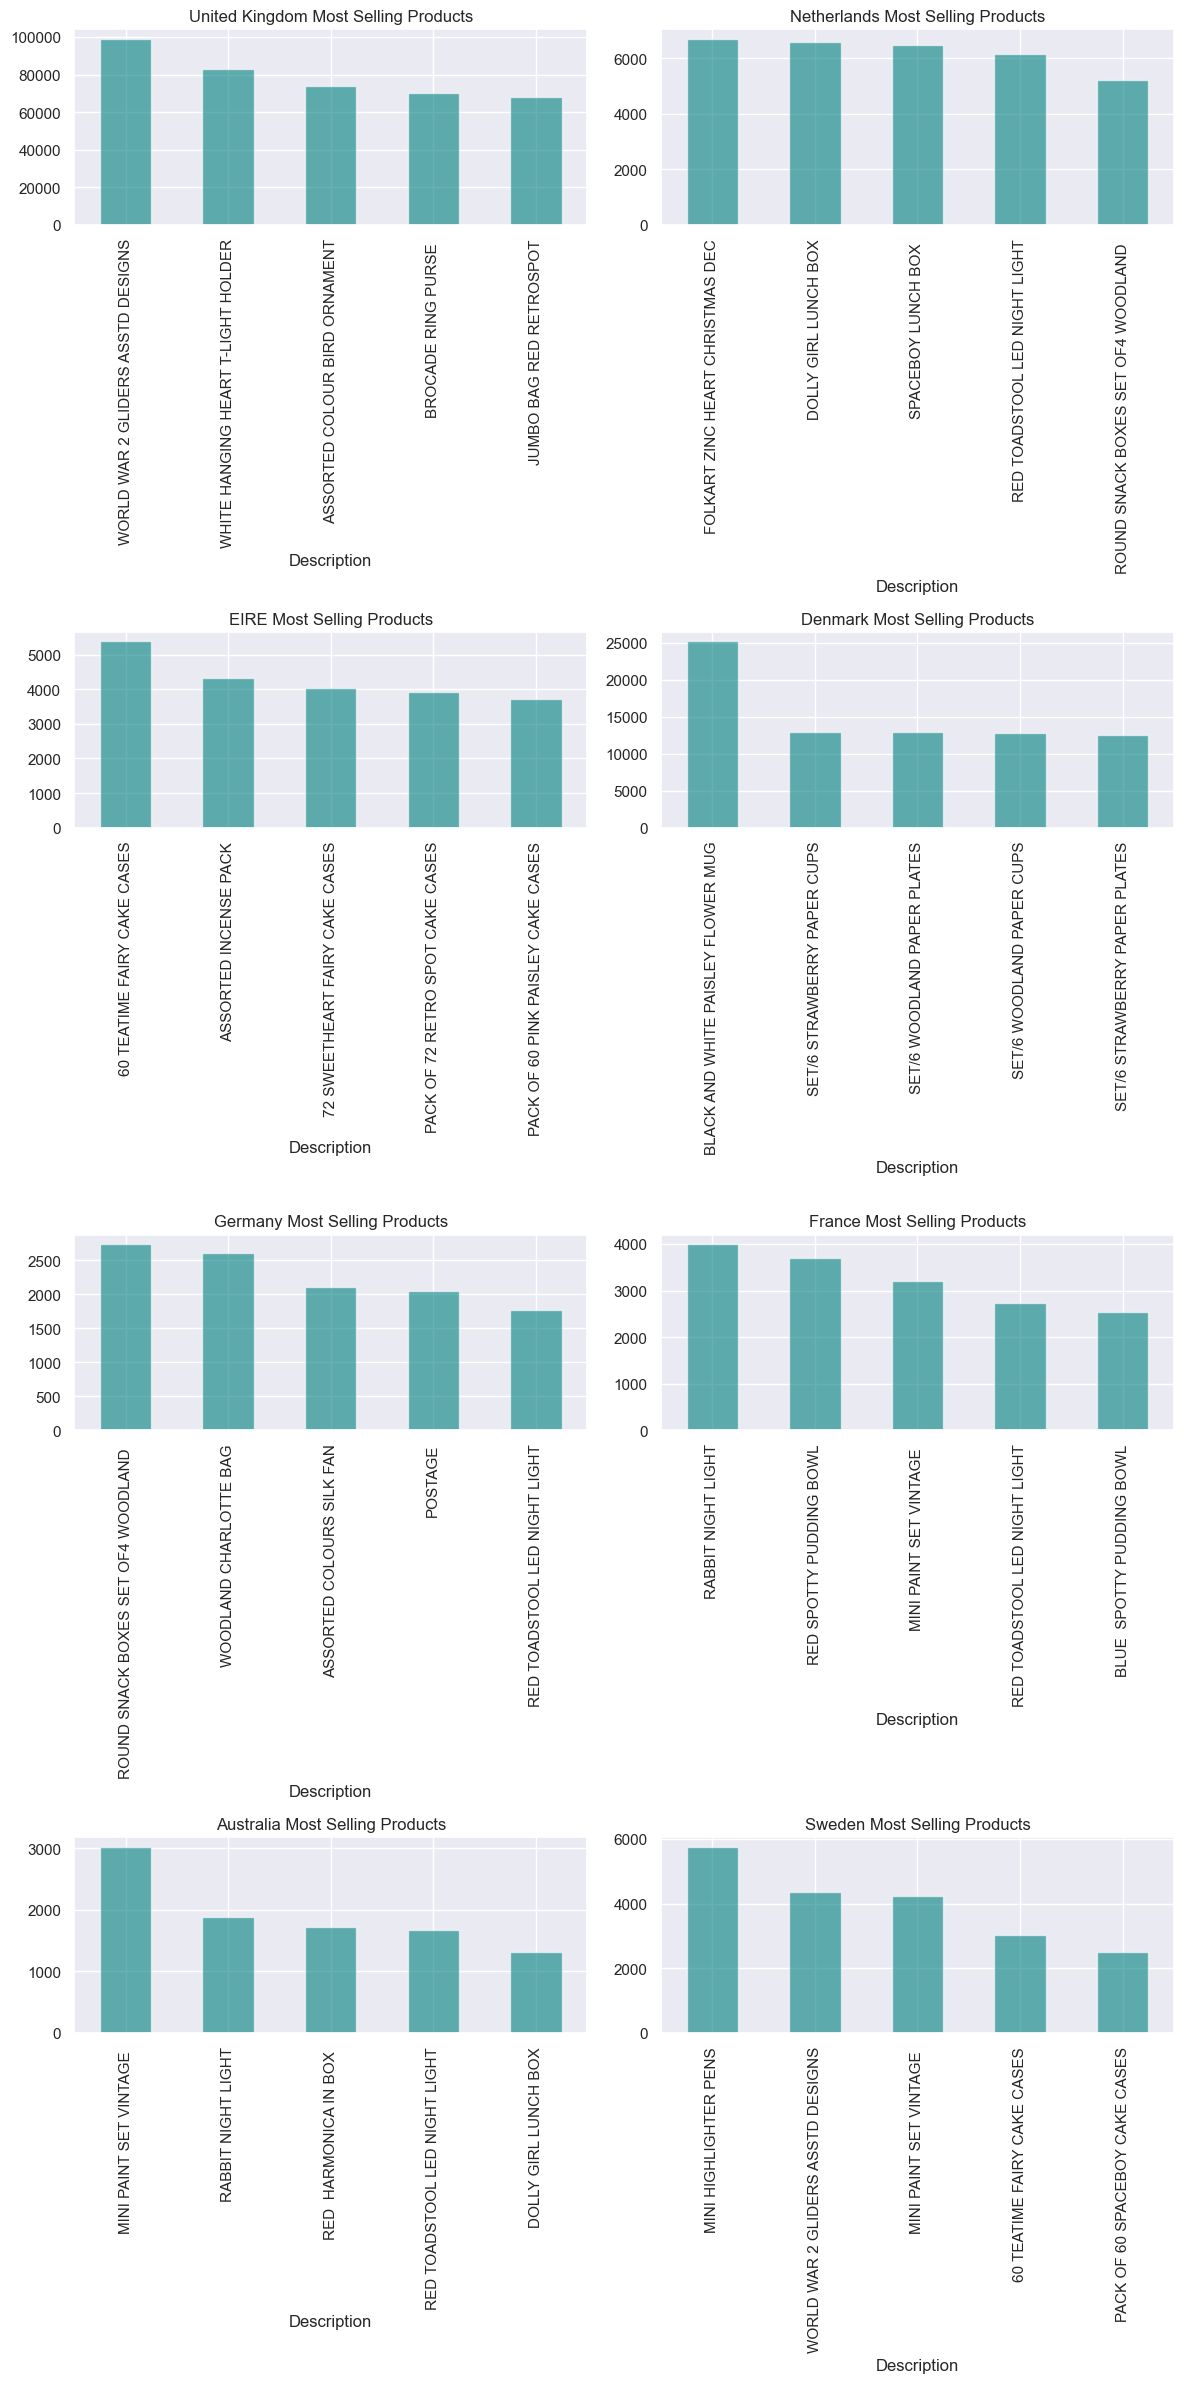

In [283]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()

### Bottom 8 Countries with Mostly Purchased Products

In [284]:
least_8_country = ["Saudi Arabia", "Nigeria", "Lebanon", "West Indies", "European Community", "Brazil", "Czech Republic", "Korea"]

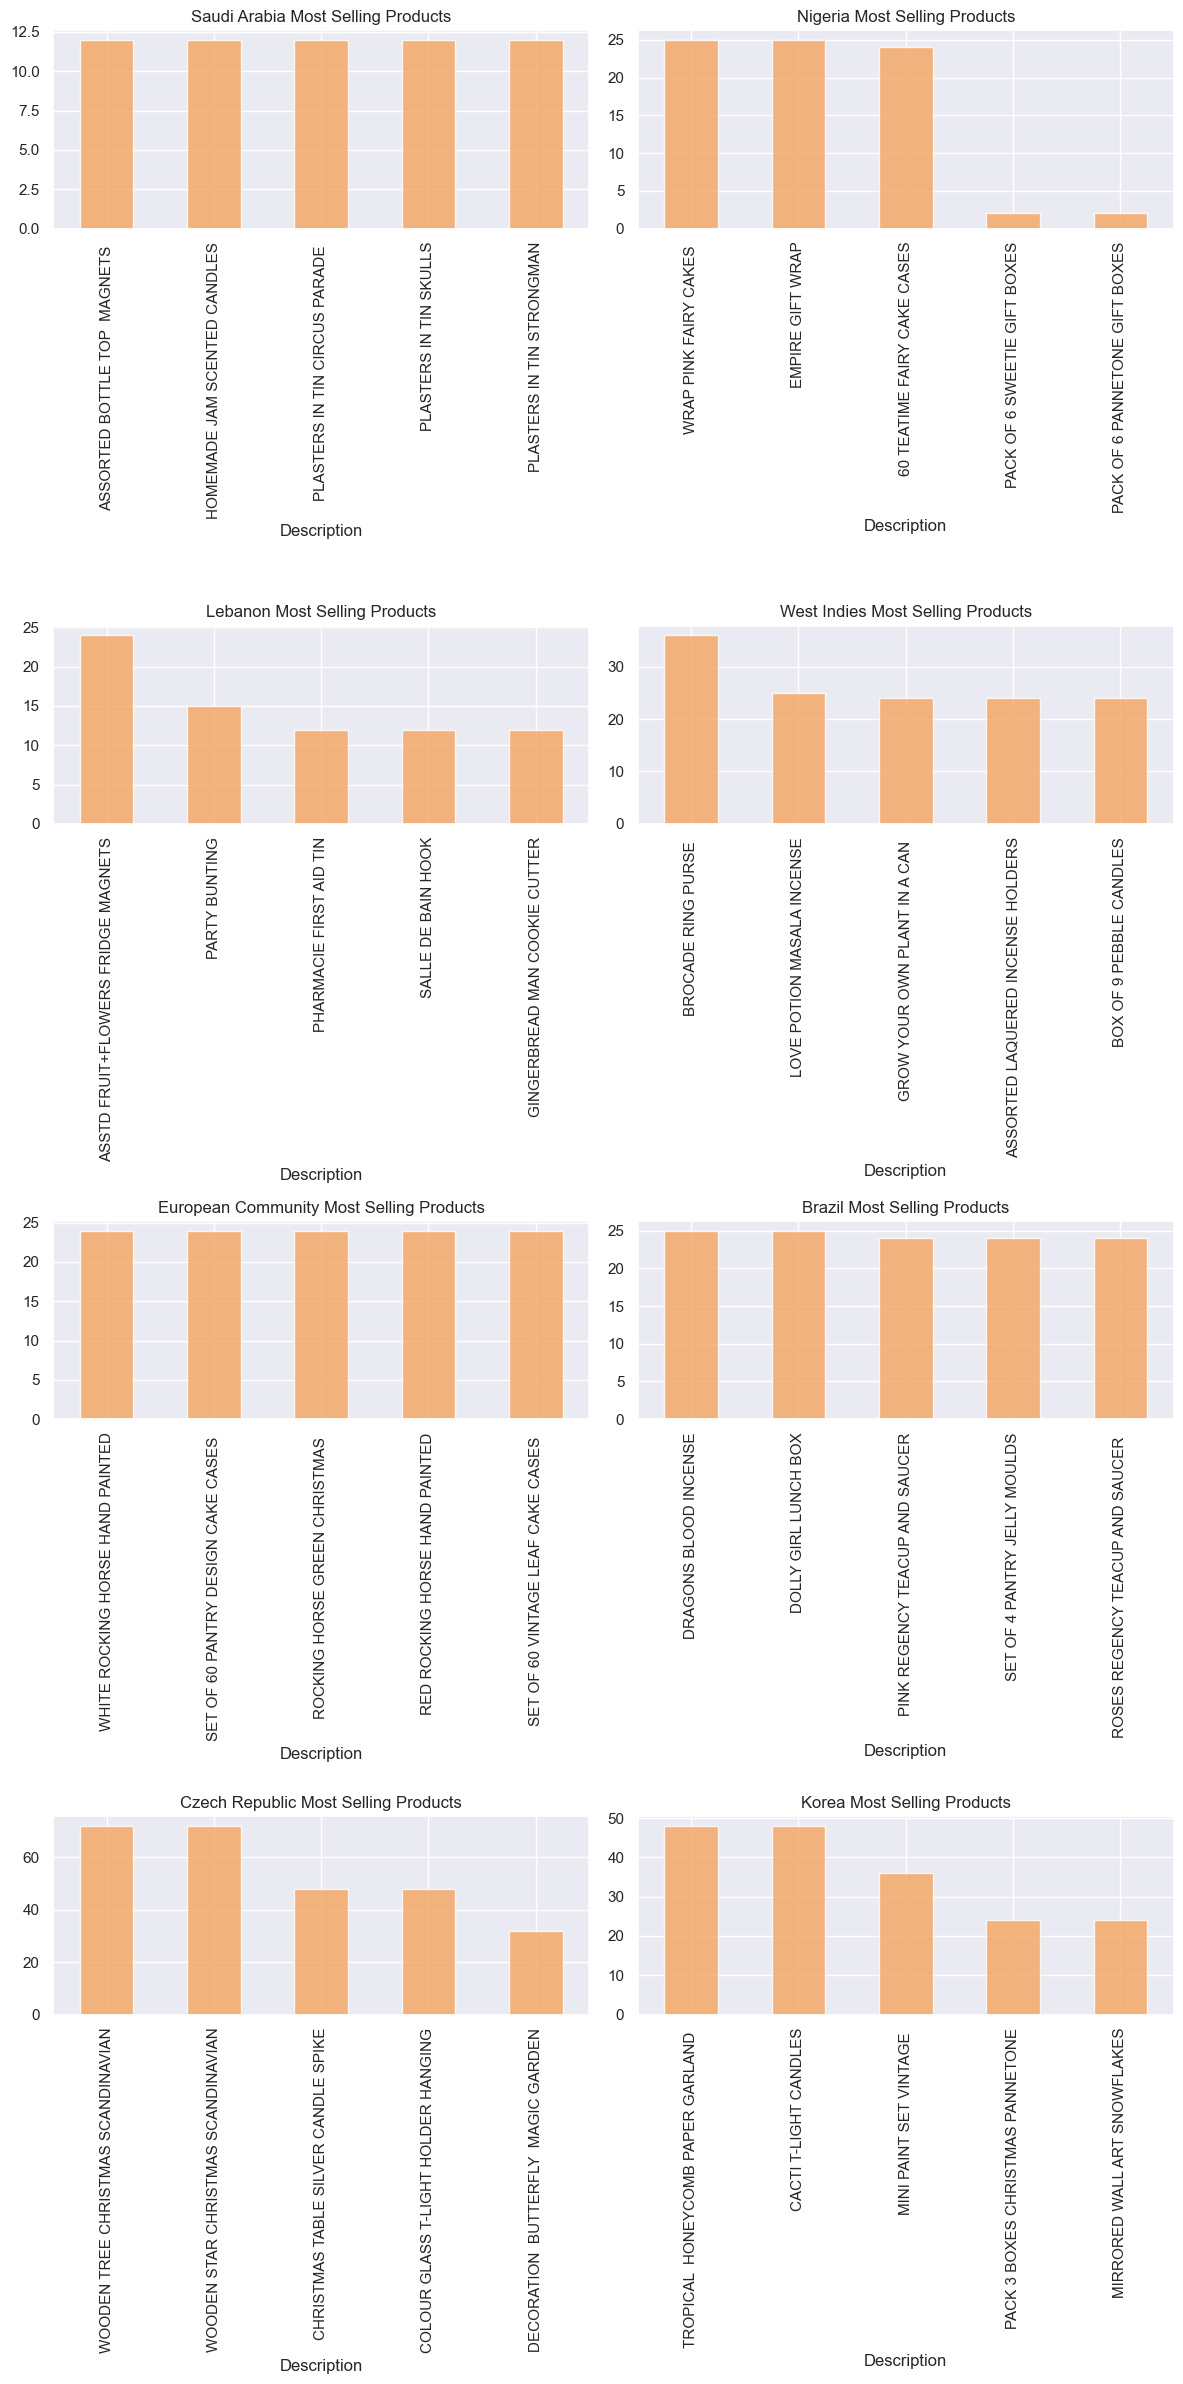

In [285]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(least_8_country):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "sandybrown", alpha = 0.8)
    
    plt.tight_layout()

### **EDA INSIGHTS:**


1) Our Top 5 Best Selling Products are **World War 2 Gliders**, **White Hanging Heart**, **Assorted Colour Bird**, **Jumbo Bag Red**, **Brocade Ring**.

2) Most Transactions happened in the month of Novemeber which is evident due to festive seasons.

3) 2010 is the year in which we have the most transactions followed by the 2011

4) Q4 being the highest when it comes transactions.

5) It also observed that in the end of the 1st week and starting of the 3rd week, people tends to buy more.

6) People loves to shop on Thursday followed by Tuesday and Wednesday.


### RFM Estimation - (Recency, Frequency, Monetary)

RFM stands for frequency, recency & monetary is a marketing technique which is used to find the best customers by analyzing their past purchasing behavior. It includes how frequently they have purchased, what is the total amount that they have spend so far, what was the last time they have purchased from our online store so on & so forth.....

In [286]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [287]:
data["Total Amount"] = data["Quantity"]*data["Price"]

In [288]:
# calculating the recency, frequency, T, monetary_value
summary = lifetimes.utils.summary_data_from_transaction_data(
    data, "Customer ID", "InvoiceDate", "Total Amount"
)

In [289]:
summary = summary.reset_index() #resetting the index

In [290]:
summary.shape

(5942, 5)

In [291]:
#idx = summary[summary["monetary_value"] <= 0].index
#summary = summary.drop(idx, axis = 0).reset_index().drop("index", axis = 1)
#print("Total Number of Negative Values: %s" % (len(summary[summary["monetary_value"] < 0]))) 

A) **T** -  T is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.

B) **Recency** - Recency is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.

C) **Frequency** - Frequency is the number of repeat purchases the customer made during the observation period.

D) **Monetary** - monetary_value is the average monetary amount of each repeat purchase made by a customer.

In [292]:
summary.head()

,Customer ID,frequency,recency,T,monetary_value
0,12346.0,10.0,400.0,725.0,-15.468000
1,12347.0,7.0,402.0,404.0,717.398571
2,12348.0,4.0,363.0,438.0,449.310000
3,12349.0,4.0,717.0,735.0,1107.172500
4,12350.0,0.0,0.0,310.0,0.000000


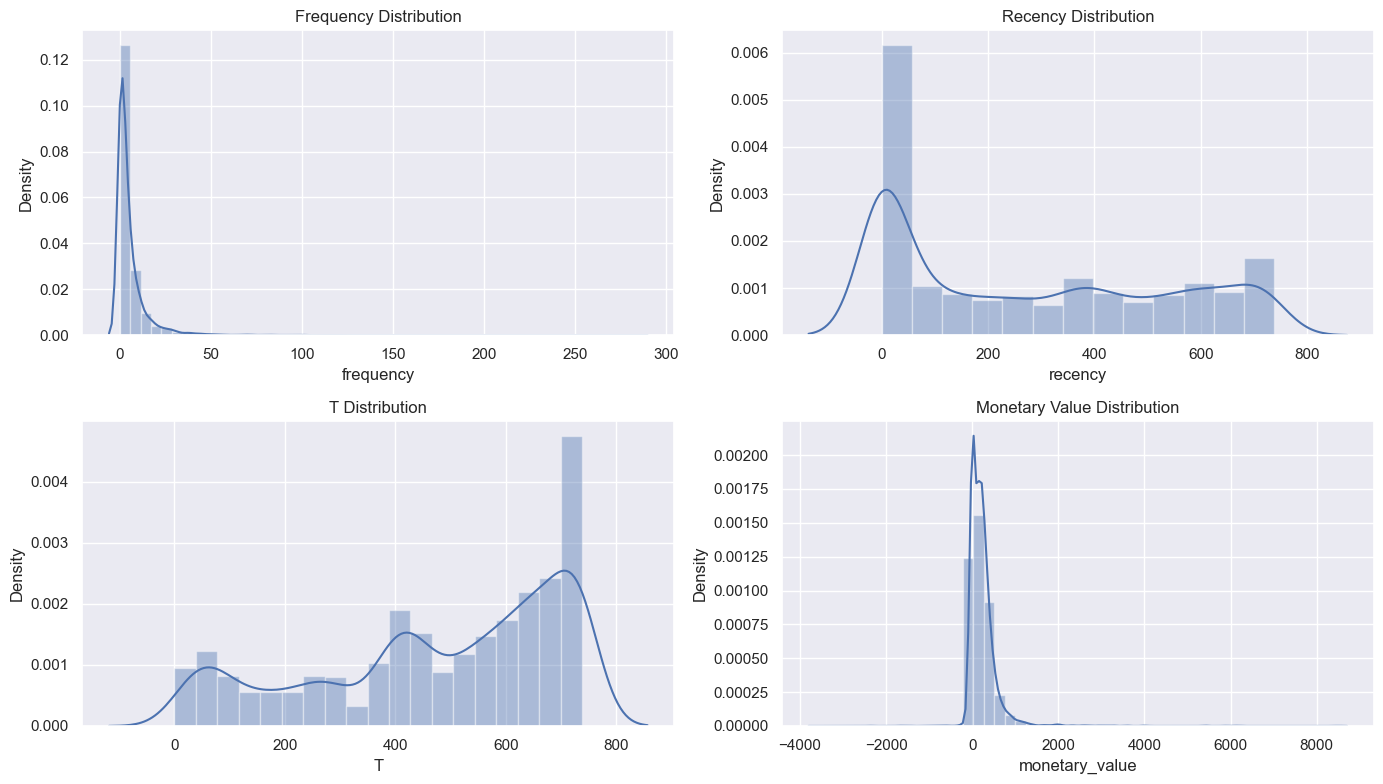

In [293]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

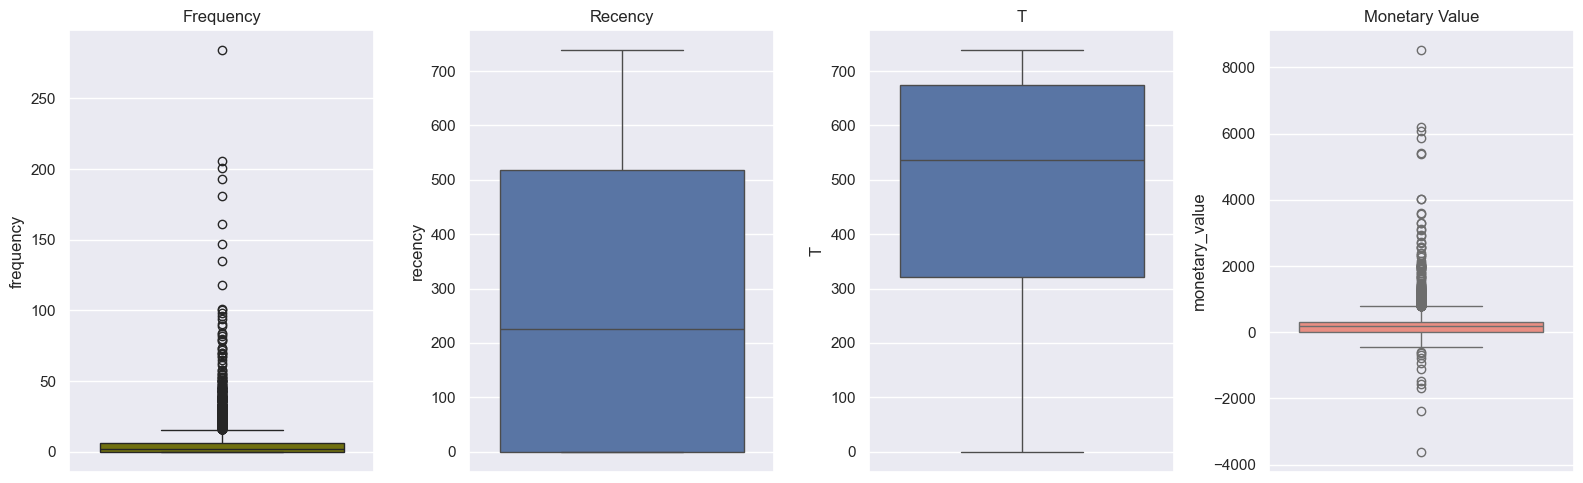

In [294]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

In [295]:
summary.describe()

,Customer ID,frequency,recency,T,monetary_value
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,5.479636,275.772299,478.229384,228.814496
std,1715.451981,11.293673,259.830840,223.879537,363.067124
min,12346.000000,0.000000,0.000000,0.000000,-3610.500000
25%,13831.250000,0.000000,0.000000,320.500000,0.000000
50%,15316.500000,2.000000,225.000000,536.000000,174.900625
75%,16801.750000,6.000000,518.000000,674.000000,314.594375
max,18287.000000,284.000000,738.000000,738.000000,8513.271143


In [296]:
#checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(summary[summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(summary[summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(summary[summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 1544
Total Number of Recency with 0: 1544
Total Number of Monetary Value with 0: 1547


Now we have the data related to the RFM, we can now start with which model we can build to predict our customer's lifetime value. First we have to figure out either we have to do the prediction based on the customer level or the aggregate level.

For this analysis I am using to predict the customer lifetime value on the customer level rather than the aggregate or a cohort level.

Before building the model, we have to understand few of the most important things. We have to understand the business context that is the type of customers **(contractual or non-contractual)** and their purchase opportunity **(discrete or continuous)**. The combination of both defines the business context which going to affect our CLV estimation approach.

**Basic Terms:**

a) **Contractual Customers** - Contractual customers are subscription based customers. They churned on a defined date if they choose not to renew the subscription.

b) **Non-Contractual Customers** -  Non Contractual customers generally exist in e-commerce or retail business where there's no defined time period when the customer is going to churn.

c) **Continuous Purchase** - It refers to the time period when the customer purchase a certain thing in any time period. Ex- Retail & E-commerce.

d) **Discrete Purchase** - It refers to the time period when the customer purchase a certain thing on a specific time period. Ex - Netflix, Hulu, Hotstar Subscription.

For this analysis we are going to use the non-contractual with continuous purchase opportunity and the best fitted models we are going to use will be BG-NBD Model, Pareto-NBD Model, Modifies BG Model along with Gamma Gamma Distribution model for estimating the expected monetary value as a part of the customer lifetime value prediction.

## Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model

In [297]:
summary_bgf = summary.copy()

In [298]:
summary_bgf.head(2)

,Customer ID,frequency,recency,T,monetary_value
0,12346.0,10.0,400.0,725.0,-15.468000
1,12347.0,7.0,402.0,404.0,717.398571


In [299]:
bgf = BetaGeoFitter(penalizer_coef = 0.0)

# We can use penalizer of 0.001 or 0.1 which we will be going to use later on based on the model performance and model selection

In [300]:
bgf.fit(summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

<lifetimes.BetaGeoFitter: fitted with 5942 subjects, a: 0.15, alpha: 49.94, b: 2.11, r: 0.67>

In [301]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.668170,0.015453,0.637882,0.698458
alpha,49.943472,1.517728,46.968725,52.918220
a,0.145498,0.014512,0.117055,0.173941
b,2.112726,0.313787,1.497704,2.727749


In [302]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5942 subjects, a: 0.15, alpha: 49.94, b: 2.11, r: 0.67>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

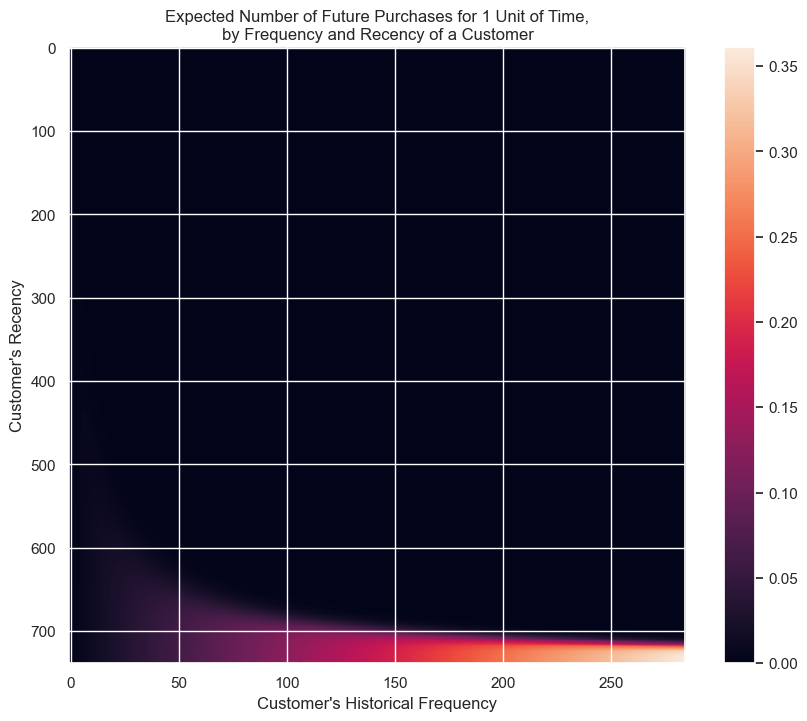

In [303]:
#plotting the frequency and recency matrix
plt.figure(figsize=(10,8))
plot_frequency_recency_matrix(bgf)

As you can see our best customers is where frequency is 250 and recency is 700+.

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

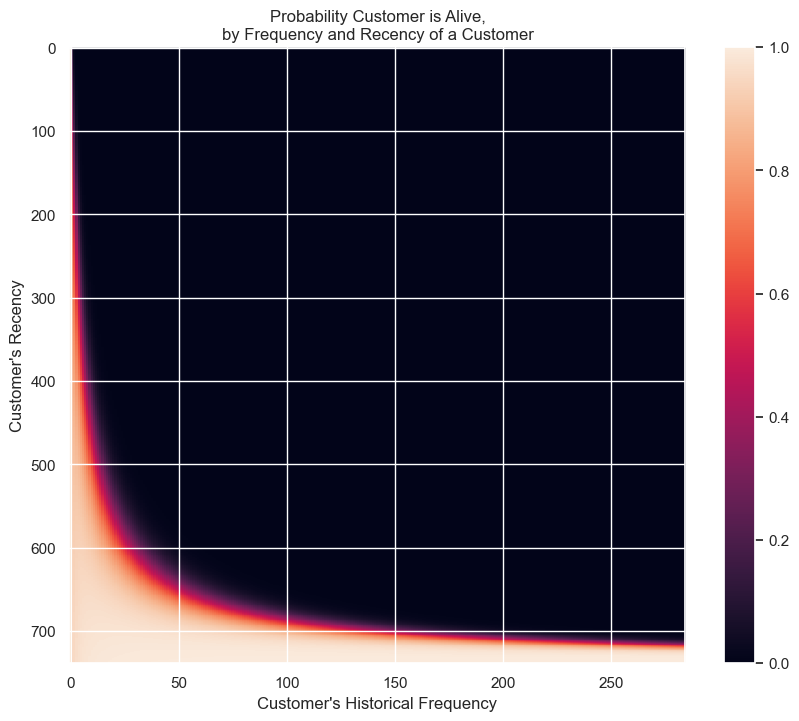

In [304]:
#plotting the churn matrix
plt.figure(figsize=(10,8))
plot_probability_alive_matrix(bgf)

As you can see our 80% customers have already churn or we can say dropped.

In [305]:
t = 30
summary_bgf["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

In [306]:
summary_bgf.sort_values(by = "predicted_purchases").tail(5)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases
2260,14606.0,181.0,735.0,736.0,165.079448,6.908522
5495,17841.0,193.0,736.0,737.0,357.437461,7.355876
2965,15311.0,201.0,738.0,738.0,560.647015,7.651860
402,12748.0,206.0,735.0,735.0,241.501117,7.871598
2565,14911.0,284.0,737.0,738.0,948.996127,10.800953


Based on the above analysis, above are the top customers who are likely to purchase in the next day.

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

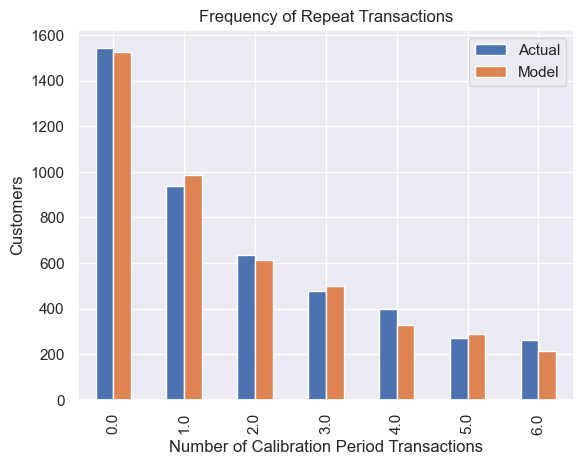

In [307]:
plot_period_transactions(bgf)

We can see that our model is doing fair job. Our model is predicting fairly good at the 0 & 2 calibration time period.

In [308]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "Customer ID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [309]:
pd.DataFrame(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [310]:
bgf.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 5025 subjects, a: 0.22, alpha: 49.70, b: 2.72, r: 0.67>

In [311]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
...,...,...,...,...,...
18283.0,9.0,458.0,474.0,9.0,184.0
18284.0,1.0,2.0,247.0,0.0,184.0
18285.0,0.0,0.0,476.0,0.0,184.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

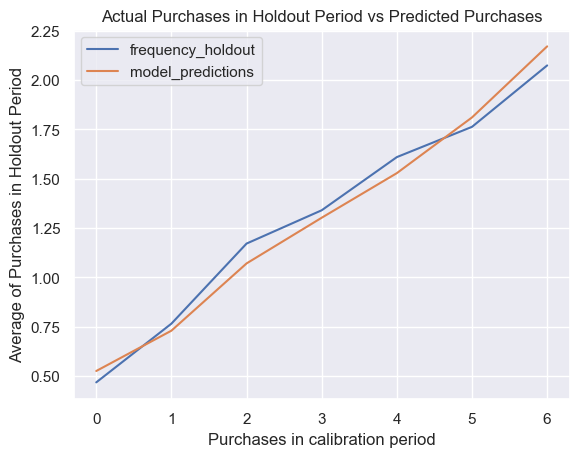

In [312]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

As we can see our model does the decent job while predicting the purchase behaviour.

In [313]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [314]:
#Creating a function which can predict the future purchased value based on the lookup window

def bgf_get_pred_error(t, id_):
    
    individual = summary_bgf[summary_bgf["Customer ID"] == id_]
    
    ind_pred = bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
    
    actual_val = individual["frequency"]/individual["recency"]*t
    
    error = actual_val - ind_pred
    
    print("Your Predicted Purchase: %s" % (ind_pred))
    print("Your Actual Purchase: %s" % (actual_val))
    print("Prediction Error: %s" % (error))

In [315]:
bgf_get_pred_error(15, 12348.0)

Your Predicted Purchase: 2    0.132161
dtype: float64
Your Actual Purchase: 2    0.165289
dtype: float64
Prediction Error: 2    0.033128
dtype: float64


In [316]:
id_1 = 14606.0
id_2 = 12347.0

In [317]:
days_since_birth = 365

In [318]:
sp_trans_1 = data[data["Customer ID"] == id_1]
sp_trans_2 = data[data["Customer ID"] == id_2]
sp_trans_1.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
7335,490024,84993B,75 BLACK PETIT FOUR CASES,5,2009-12-03 12:40:00,0.42,14606.0,United Kingdom,2.10
7336,490024,21944,KITTENS DESIGN FLANNEL,1,2009-12-03 12:40:00,0.85,14606.0,United Kingdom,0.85
7337,490024,20718,RED SPOTTY SHOPPER BAG,1,2009-12-03 12:40:00,1.25,14606.0,United Kingdom,1.25
7338,490024,20749,ASSORTED COLOUR MINI CASES,2,2009-12-03 12:40:00,7.95,14606.0,United Kingdom,15.90
7339,490024,21536,DAIRY MAID SMALL MILK JUG,1,2009-12-03 12:40:00,2.10,14606.0,United Kingdom,2.10
7340,490024,21232,STRAWBERRY CERAMIC TRINKET BOX,2,2009-12-03 12:40:00,1.25,14606.0,United Kingdom,2.50
7341,490024,84519A,TOMATO CHARLIE+LOLA COASTER SET,1,2009-12-03 12:40:00,2.95,14606.0,United Kingdom,2.95
7342,490024,90214J,"LETTER ""J"" BLING KEY RING",1,2009-12-03 12:40:00,1.25,14606.0,United Kingdom,1.25
7343,490024,90214C,"LETTER ""C"" BLING KEY RING",1,2009-12-03 12:40:00,1.25,14606.0,United Kingdom,1.25
7344,490024,90214H,"LETTER ""H"" BLING KEY RING",1,2009-12-03 12:40:00,1.25,14606.0,United Kingdom,1.25


In [319]:
#plt.figure(figsize=(8, 6))
#plot_history_alive(bgf, days_since_birth, sp_trans_1, "InvoiceDate")

In [320]:
#plt.figure(figsize=(8,6))
#plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

As we can see in the above plot, after doing purchase on a certain time period, our customer will get's activated again.

In [321]:
summary_bgf["actual_30"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [322]:
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.0,10.0,400.0,725.0,-15.468000,0.077362,0.750000
1,12347.0,7.0,402.0,404.0,717.398571,0.495352,0.522388
2,12348.0,4.0,363.0,438.0,449.310000,0.269178,0.330579
3,12349.0,4.0,717.0,735.0,1107.172500,0.172500,0.167364
4,12350.0,0.0,0.0,310.0,0.000000,0.055446,NaN


In [323]:
summary_bgf = summary_bgf.fillna(value = 0) #filling null values with 0

In [324]:
#calculating the prediction error for the 30 days purchase prediction
summary_bgf["Error"] = summary_bgf["actual_30"] - summary_bgf["predicted_purchases"]

In [325]:
mse = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])

In [326]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_bgf["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 4.337882659974867
Average Error:  0.41179765536782703
Root Mean Squared Error: 2.082758425736136


In [327]:
#Purchase Prediction

bgf_mse_purchase_30 = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
bgf_rmse_purchase_30 = sqrt(bgf_mse_purchase_30)
bgf_avg_error_purchase_30 = summary_bgf["Error"].mean()

**Note:** This error is based on the 30 days lookup window, it may vary as you adjust the lookup window time.

In [328]:
summary_bgf.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.0,10.0,400.0,725.0,-15.468000,0.077362,0.750000,0.672638
1,12347.0,7.0,402.0,404.0,717.398571,0.495352,0.522388,0.027036
2,12348.0,4.0,363.0,438.0,449.310000,0.269178,0.330579,0.061401
3,12349.0,4.0,717.0,735.0,1107.172500,0.172500,0.167364,-0.005136
4,12350.0,0.0,0.0,310.0,0.000000,0.055446,0.000000,-0.055446


In [329]:
#Filtering the data where we have the values of 0 or less than 0.
res_summary = summary_bgf[summary_bgf["frequency"] > 0]

In [330]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

<Axes: >

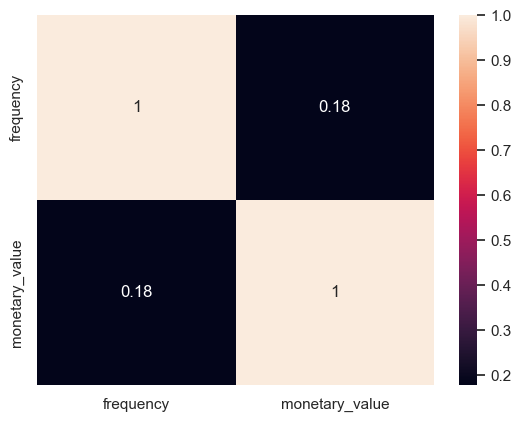

In [331]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model.

In [332]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [333]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [334]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [335]:
summary_bgf.head(2)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.0,10.0,400.0,725.0,-15.468000,0.077362,0.750000,0.672638
1,12347.0,7.0,402.0,404.0,717.398571,0.495352,0.522388,0.027036


In [336]:
summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]

In [337]:
summary_.shape

(4185, 8)

In [338]:
summary_["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_["frequency"], 
                                                                        summary_["monetary_value"])

In [339]:
summary_.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
1,12347.0,7.0,402.0,404.0,717.398571,0.495352,0.522388,0.027036,629.556290
2,12348.0,4.0,363.0,438.0,449.310000,0.269178,0.330579,0.061401,409.972301
3,12349.0,4.0,717.0,735.0,1107.172500,0.172500,0.167364,-0.005136,842.513995
6,12352.0,8.0,356.0,392.0,218.182500,0.566836,0.674157,0.107321,242.209404
7,12353.0,1.0,204.0,408.0,89.000000,0.091934,0.147059,0.055125,254.858476


In [340]:
print("Expected Average Sales: %s" % summary_["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_["monetary_value"].mean())
print("Difference: %s" % (summary_["monetary_value"].mean() - summary_["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"])))

Expected Average Sales: 340.18897558292775
Actual Average Sales: 330.6608495198251
Difference: -9.528126063102661
Mean Squared Error: 20896.88188078893
Root Mean Squared Error: 144.55753830495638


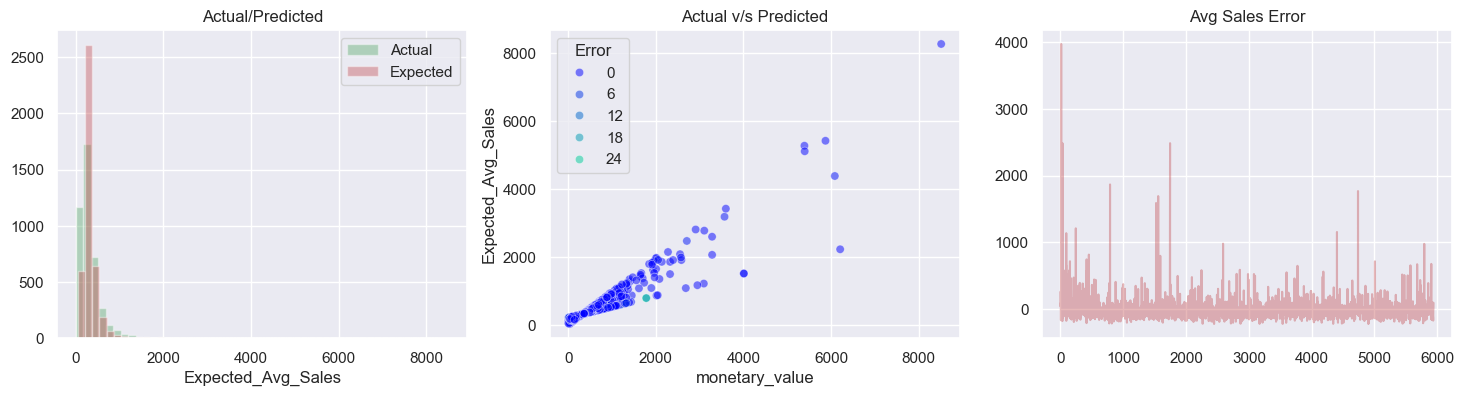

In [341]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
sns.distplot(summary_["monetary_value"], color="g", kde=False)
sns.distplot(summary_["Expected_Avg_Sales"], color="r", kde=False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(
    x=summary_["monetary_value"],
    y=summary_["Expected_Avg_Sales"],
    alpha=0.5,
    hue=summary_["Error"],
    palette="winter",
)
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(
    summary_["monetary_value"] - summary_["Expected_Avg_Sales"], color="r", alpha=0.4
)
plt.title("Avg Sales Error")
plt.show()

In [342]:
summary_["predicted_clv"] = ggf.customer_lifetime_value(
    bgf,
    summary_["frequency"],
    summary_["recency"],
    summary_["T"],
    summary_["monetary_value"],
    time=30,
    freq="D",
    discount_rate=0.01,
)

In [343]:
summary_.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
1,12347.0,7.0,402.0,404.0,717.398571,0.495352,0.522388,0.027036,629.556290,7110.166375
2,12348.0,4.0,363.0,438.0,449.310000,0.269178,0.330579,0.061401,409.972301,2512.081673
3,12349.0,4.0,717.0,735.0,1107.172500,0.172500,0.167364,-0.005136,842.513995,3449.798774
6,12352.0,8.0,356.0,392.0,218.182500,0.566836,0.674157,0.107321,242.209404,3100.010138
7,12353.0,1.0,204.0,408.0,89.000000,0.091934,0.147059,0.055125,254.858476,536.035114


In [344]:
#manual calculation of CLV
#summary_["predicted_purchases"] * summary_["Expected_Avg_Sales"]

In [345]:
#adding a 5% of profit margin
summary_["CLV"] = summary_["predicted_clv"]*0.05

In [346]:
summary_[summary_["Customer ID"] == 13902.0]

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
1556,13902.0,5.0,99.0,731.0,6085.692,0.000758,1.515152,1.514393,4393.947298,56.677321,2.833866


In [347]:
summary_.sort_values(by = "Error", ascending = False)

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
5276,17622.0,2.0,2.0,598.0,194.145,0.003059,30.000000,29.996941,265.738713,14.937363,0.746868
3448,15794.0,1.0,1.0,737.0,102.000,0.008321,30.000000,29.991679,259.074204,44.309988,2.215499
2884,15230.0,1.0,1.0,240.0,59.400,0.076162,30.000000,29.923838,245.259590,381.340230,19.067012
5045,17391.0,1.0,1.0,164.0,101.760,0.132262,30.000000,29.867738,258.996375,696.754608,34.837730
2446,14792.0,1.0,1.0,64.0,6.200,0.342512,30.000000,29.657488,228.007537,1549.261568,77.463078
...,...,...,...,...,...,...,...,...,...,...,...
1677,14023.0,1.0,243.0,250.0,310.930,0.154797,0.123457,-0.031340,326.827426,1139.053953,56.952698
4149,16495.0,1.0,273.0,276.0,437.900,0.142739,0.109890,-0.032849,368.002110,1191.242796,59.562140
2174,14520.0,1.0,289.0,290.0,105.600,0.136983,0.103806,-0.033177,260.241636,811.317591,40.565880
4904,17250.0,1.0,258.0,261.0,221.870,0.149580,0.116279,-0.033301,297.946452,1006.736400,50.336820


In [348]:
actual = summary_["monetary_value"]*summary_["actual_30"]

In [349]:
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]

In [350]:
error = actual - pred

In [351]:
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [352]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result["Actual"], result["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 108.1982810316359
Mean Squared Error: 907287.2534810009
Root Mean Squared Error: 952.5162746541399


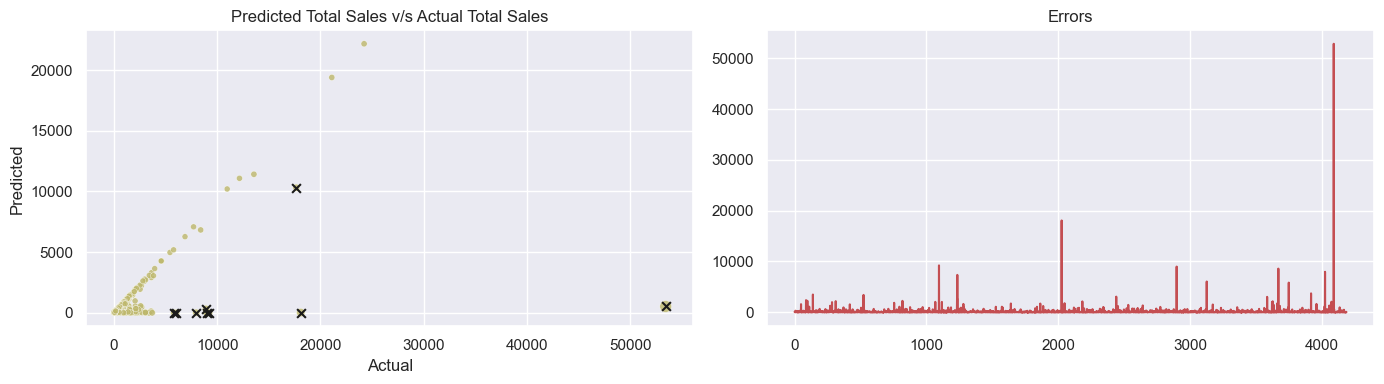

In [353]:
# Predicted v/s Actual
plt.figure(figsize=(14, 4))
plt.subplot(121)
sns.scatterplot(
    data=result,
    x="Actual",
    y="Predicted",
    size="Error",
    color="darkkhaki",
    alpha=0.8,
    marker="o",
    legend=False,
)
plt.scatter(
    result[result["Error"] > 5000]["Actual"],
    result[result["Error"] > 5000]["Predicted"],
    color="k",
    marker="x",
    s=40,
)
plt.title("Predicted Total Sales v/s Actual Total Sales")
plt.subplot(122)
plt.plot(result["Error"].values, color="r")
plt.title("Errors")
plt.tight_layout()
plt.show()

## Pareto - Negative Binom Distribution + Gamma Gamma Distribution Model

In [354]:
summary_pnbd = summary.copy()

In [355]:
summary_pnbd.shape

(5942, 5)

In [356]:
pareto_nbd = ParetoNBDFitter(penalizer_coef = 0.0)
pareto_nbd.fit(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

<lifetimes.ParetoNBDFitter: fitted with 5942 subjects, alpha: 63.88, beta: 124.23, r: 0.83, s: 0.16>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

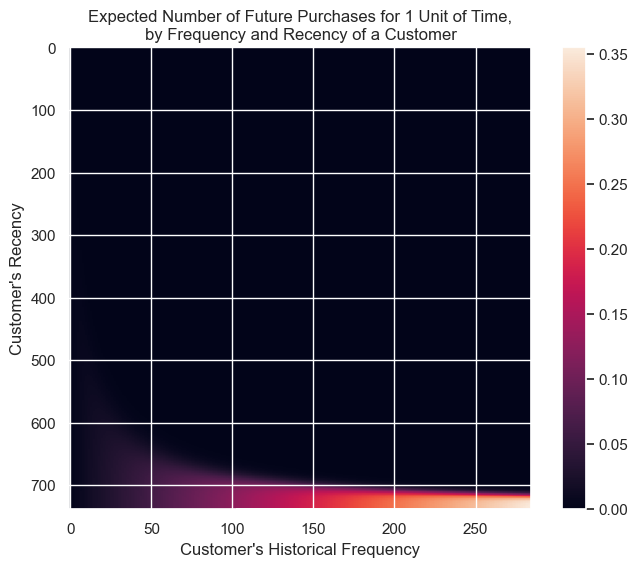

In [357]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(pareto_nbd)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

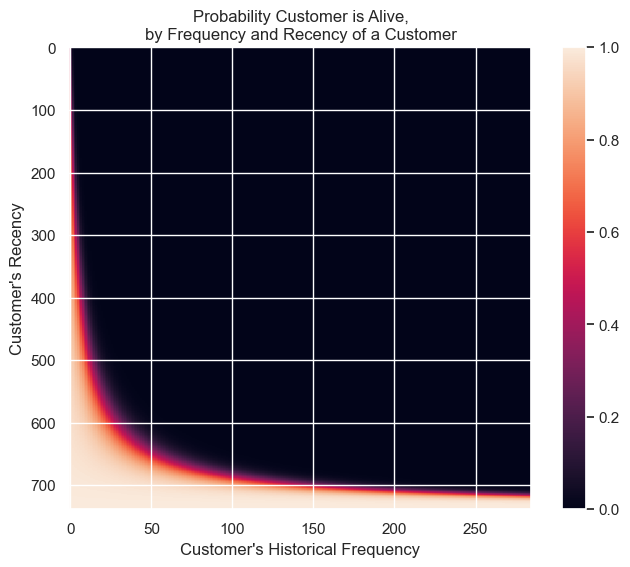

In [358]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(pareto_nbd)

In [359]:
summary_pnbd["p_not_alive"] = 1-pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])
summary_pnbd["p_alive"] = pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

In [360]:
t = 30
summary_pnbd["predicted_purchases"] = pareto_nbd.conditional_expected_number_of_purchases_up_to_time(t, summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

In [361]:
summary_pnbd.sort_values(by = "predicted_purchases").tail(5)

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
2260,14606.0,181.0,735.0,736.0,165.079448,0.000215,0.999785,6.799060
5495,17841.0,193.0,736.0,737.0,357.437461,0.000216,0.999784,7.238721
2565,14911.0,284.0,737.0,738.0,948.996127,0.000229,0.999771,10.623730
402,12748.0,206.0,735.0,735.0,241.501117,NaN,NaN,NaN
2965,15311.0,201.0,738.0,738.0,560.647015,NaN,NaN,NaN


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

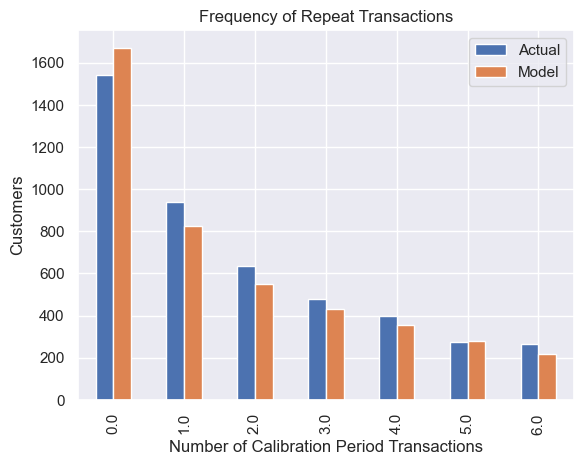

In [362]:
plot_period_transactions(pareto_nbd)

In [363]:
# dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(
    data,
    "Customer ID",
    "InvoiceDate",
    calibration_period_end="2011-06-08",
    observation_period_end="2011-12-09",
)

In [364]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,10.0,400.0,541.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,3.0,328.0,551.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [365]:
pareto_nbd.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 5025 subjects, alpha: 63.62, beta: 1301.20, r: 0.82, s: 1.16>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

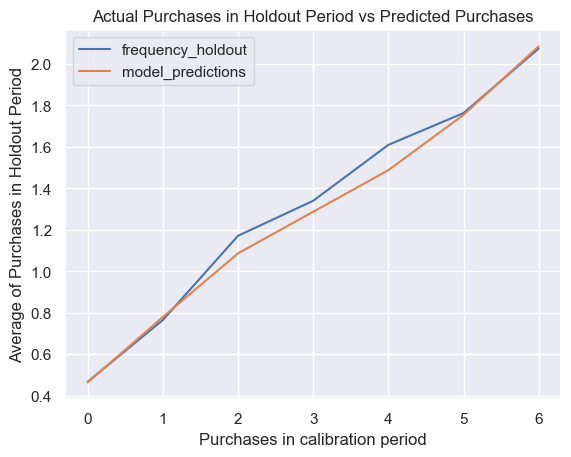

In [366]:
plot_calibration_purchases_vs_holdout_purchases(pareto_nbd, pareto_summary_cal_holdout)

In [367]:
# Creating a function which can predict the future purchased value based on the lookup window


def pareto_get_pred_error(t, id_):
    individual_p = summary_pnbd[summary_pnbd["Customer ID"] == id_]

    ind_pred_p = pareto_nbd.predict(
        t, individual_p["frequency"], individual_p["recency"], individual_p["T"]
    )

    actual_val_p = individual_p["frequency"] / individual_p["recency"] * t

    error = actual_val_p - ind_pred_p

    print("Your Predicted Purchase: %s" % (ind_pred_p))
    print("Your Actual Purchase: %s" % (actual_val_p))
    print("Prediction Error: %s" % (error))

In [368]:
pareto_get_pred_error(30, 12346.0)

Your Predicted Purchase: 0    0.032557
dtype: float64
Your Actual Purchase: 0    0.75
dtype: float64
Prediction Error: 0    0.717443
dtype: float64


In [369]:
summary_pnbd["actual_30_p"] = summary_pnbd["frequency"]/summary_pnbd["recency"]*30

In [370]:
summary_pnbd["actual_30_p"].fillna(0, inplace = True)

In [371]:
summary_pnbd["p_error"] = summary_pnbd["actual_30_p"]-summary_pnbd["predicted_purchases"]

In [372]:
# Drop rows with NaNs in the relevant columns before computing metrics
_metrics_df = summary_pnbd[["actual_30_p", "predicted_purchases", "p_error"]].dropna()
if _metrics_df.shape[0] == 0:
    raise ValueError(
        "No non-NaN rows found in 'actual_30_p'/'predicted_purchases'/'p_error'"
    )

mse = mean_squared_error(_metrics_df["actual_30_p"], _metrics_df["predicted_purchases"])
rmse = sqrt(mse)
avg_error = _metrics_df["p_error"].mean()

mse, rmse, avg_error

(4.33725509703587, 2.0826077636069327, np.float64(0.41228785092569475))

In [373]:
mask = summary_pnbd[["actual_30_p", "predicted_purchases"]].notnull().all(axis=1)
actual = summary_pnbd.loc[mask, "actual_30_p"]
pred = summary_pnbd.loc[mask, "predicted_purchases"]
pareto_mse_purchase = mean_squared_error(actual, pred)
pareto_rmse_purchase = sqrt(pareto_mse_purchase)
pareto_avg_error_purchase = summary_pnbd["p_error"].mean(skipna=True)

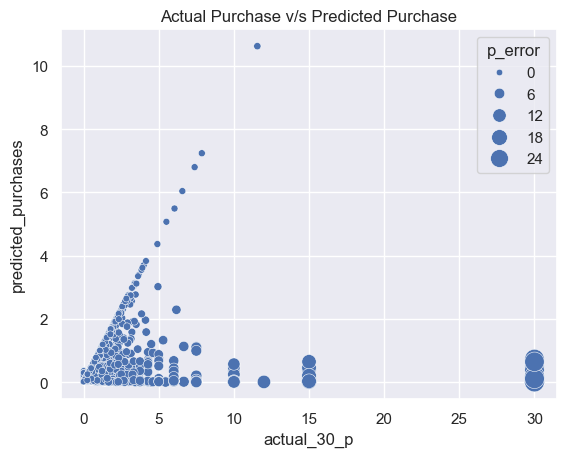

In [374]:
sns.scatterplot(
    data=summary_pnbd,
    x="actual_30_p",
    y="predicted_purchases",
    size="p_error",
    sizes=(20, 200),
)
plt.title("Actual Purchase v/s Predicted Purchase")
plt.show()

In [375]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["Customer ID"] == id_]
    plot_history_alive(pareto_nbd, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

In [376]:
#get_history_alive(pd.Timedelta(days=365), data, 12352.0)

In [377]:
summary_copy = summary_pnbd.copy()

In [378]:
summary_copy = summary_copy[(summary_copy["frequency"] > 0) & (summary_copy["monetary_value"] > 0)]

<Axes: >

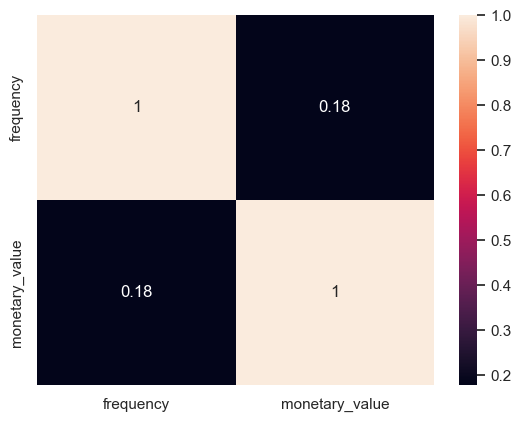

In [379]:
sns.heatmap(summary_copy[["frequency", "monetary_value"]].corr(), annot = True)

In [380]:
ggf_p = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [381]:
ggf_p.fit(summary_copy["frequency"], summary_copy["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [382]:
ggf_p.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [383]:
summary_copy["expected_avg_sales_p"] = ggf_p.conditional_expected_average_profit(summary_copy["frequency"],
                                                                        summary_copy["monetary_value"])

In [384]:
summary_copy.head()

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p
1,12347.0,7.0,402.0,404.0,717.398571,0.000634,0.999366,0.499741,0.522388,0.022647,629.556290
2,12348.0,4.0,363.0,438.0,449.310000,0.034902,0.965098,0.277710,0.330579,0.052868,409.972301
3,12349.0,4.0,717.0,735.0,1107.172500,0.003675,0.996325,0.180376,0.167364,-0.013012,842.513995
6,12352.0,8.0,356.0,392.0,218.182500,0.017284,0.982716,0.568664,0.674157,0.105493,242.209404
7,12353.0,1.0,204.0,408.0,89.000000,0.126962,0.873038,0.101372,0.147059,0.045687,254.858476


In [385]:
avg_purchase_error = summary_copy["monetary_value"].mean() - summary_copy["expected_avg_sales_p"].mean()

In [386]:
print("Acutal Avg Sales: %s" % summary_copy["monetary_value"].mean())
print("Predicted Avg Sales: %s" % summary_copy["expected_avg_sales_p"].mean())
print(
    "Mean Sqaured Error: %s"
    % mean_squared_error(
        summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"]
    )
)
print(
    "Root Mean Sqaured Error: %s"
    % sqrt(
        mean_squared_error(
            summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"]
        )
    )
)
print("Avg Sales Error: %s" % avg_purchase_error)

Acutal Avg Sales: 330.6608495198251
Predicted Avg Sales: 340.18897558292775
Mean Sqaured Error: 20896.88188078893
Root Mean Sqaured Error: 144.55753830495638
Avg Sales Error: -9.528126063102661


In [387]:
actual = summary_copy["actual_30_p"] * summary_copy["monetary_value"]
predicted = summary_copy["predicted_purchases"] * summary_copy["expected_avg_sales_p"]

In [388]:
error = actual-predicted

In [389]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T

In [390]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: 108.09059191135562


ValueError: Input contains NaN.

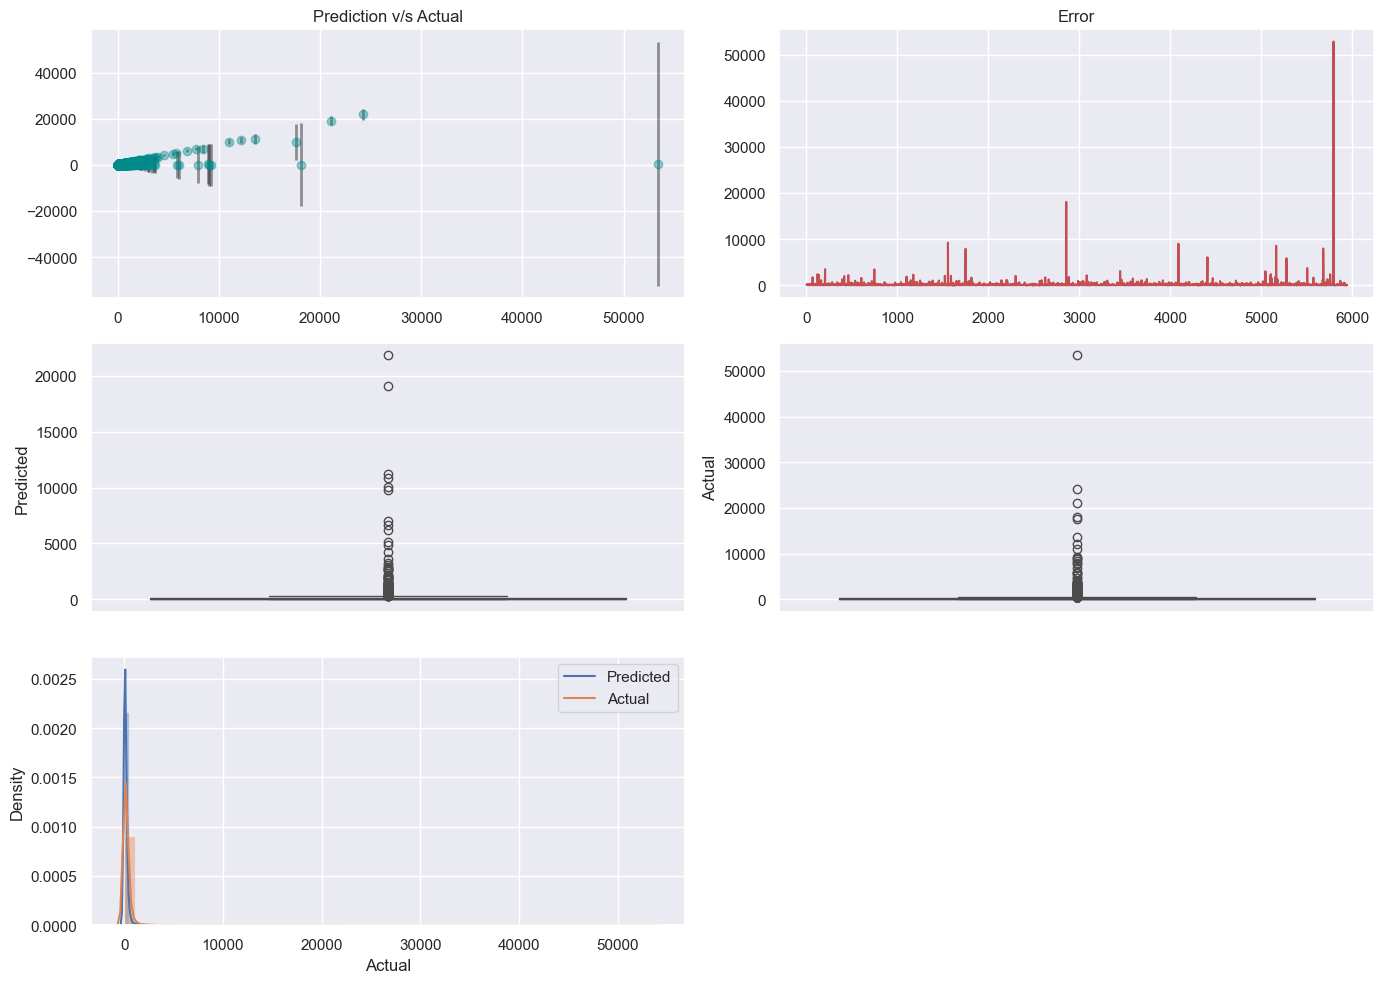

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(321)
plt.errorbar(
    result_p["Actual"],
    result_p["Predicted"],
    yerr=np.abs(result_p["Error"]),
    fmt="o",
    color="darkcyan",
    ecolor="black",
    elinewidth=2,
    capsize=0,
    alpha=0.4,
)
plt.title("Prediction v/s Actual")
plt.subplot(322)
plt.plot(result_p["Error"], color="r")
plt.title("Error")
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.tight_layout()


In [ ]:
summary_copy["predicted_clv_p"] = ggf_p.customer_lifetime_value(
    pareto_nbd,
    summary_copy["frequency"],
    summary_copy["recency"],
    summary_copy["T"],
    summary_copy["monetary_value"],
    time=30,
    freq="D",
    discount_rate=0.01,
)

In [ ]:
summary_copy.shape

(4185, 12)

In [ ]:
summary_copy["CLV_p"] = summary_copy["predicted_clv_p"]*0.05

In [ ]:
summary_copy.head()

,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p,predicted_clv_p,CLV_p
1,12347.0,7.0,402.0,404.0,717.398571,0.000921,0.999079,0.497786,0.522388,0.024602,629.556290,6324.522076,316.226104
2,12348.0,4.0,363.0,438.0,449.310000,0.049566,0.950434,0.271350,0.330579,0.059229,409.972301,2199.638346,109.981917
3,12349.0,4.0,717.0,735.0,1107.172500,0.007143,0.992857,0.177975,0.167364,-0.010611,842.513995,3115.671090,155.783555
6,12352.0,8.0,356.0,392.0,218.182500,0.023979,0.976021,0.563229,0.674157,0.110928,242.209404,2714.514830,135.725741
7,12353.0,1.0,204.0,408.0,89.000000,0.148899,0.851101,0.096501,0.147059,0.050557,254.858476,464.556727,23.227836


In [ ]:
#with open("summary_copy_pareto_model.pkl", "wb") as fh:
    #pickle.dump(summary_copy, fh)
#with open("summary_copy_bg_nbd_model.pkl", "wb") as fh:
    #pickle.dump(summary_, fh)    

## Modified Beta Geom + Gamma Gamma Distribution Model

In [ ]:
summary_mbg = summary.copy()

In [ ]:
summary_mbg.head()

,Customer ID,frequency,recency,T,monetary_value
0,12346.0,10.0,400.0,725.0,-15.468000
1,12347.0,7.0,402.0,404.0,717.398571
2,12348.0,4.0,363.0,438.0,449.310000
3,12349.0,4.0,717.0,735.0,1107.172500
4,12350.0,0.0,0.0,310.0,0.000000


In [ ]:
mbg = ModifiedBetaGeoFitter(penalizer_coef = 0.0)
mbg.fit(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 5942 subjects, a: 0.18, alpha: 57.90, b: 2.05, r: 0.84>

In [ ]:
mbg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.837666,0.029295,0.780247,0.895084
alpha,57.895342,1.972543,54.029159,61.761525
a,0.180562,0.015152,0.150864,0.210260
b,2.045383,0.314244,1.429466,2.661301


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

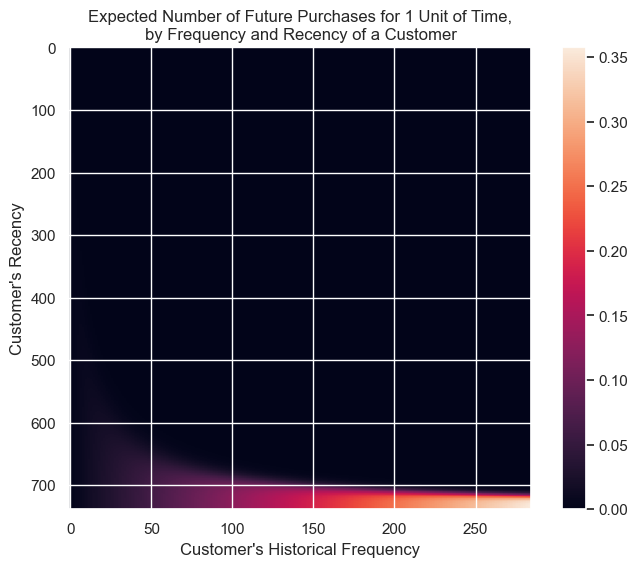

In [ ]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(mbg)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

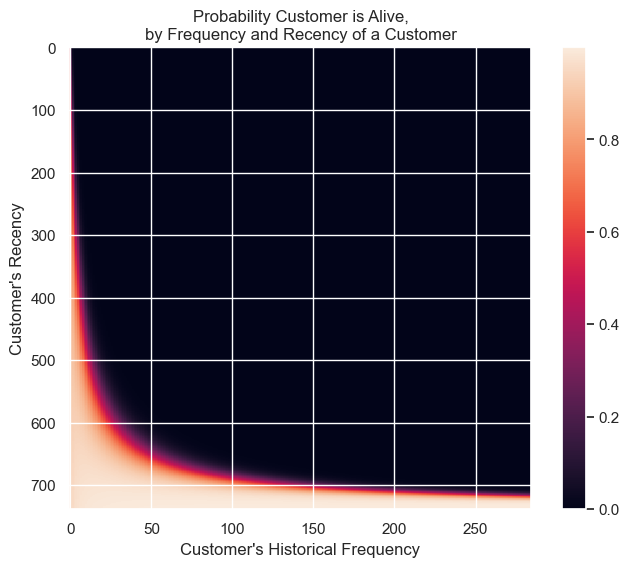

In [ ]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(mbg)

In [ ]:
t = 30
summary_mbg["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

In [ ]:
summary_mbg

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases
0,12346.0,10.0,400.0,725.0,-15.468000,0.056541
1,12347.0,7.0,402.0,404.0,717.398571,0.491299
2,12348.0,4.0,363.0,438.0,449.310000,0.263606
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685
4,12350.0,0.0,0.0,310.0,0.000000,0.055882
...,...,...,...,...,...,...
5937,18283.0,18.0,655.0,658.0,146.405556,0.778669
5938,18284.0,1.0,2.0,431.0,-25.000000,0.023597
5939,18285.0,0.0,0.0,660.0,0.000000,0.028394
5940,18286.0,2.0,247.0,723.0,362.740000,0.058435


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

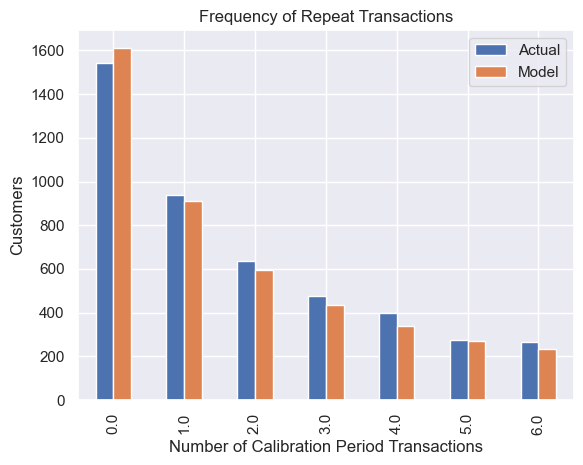

In [ ]:
plot_period_transactions(mbg)

In [ ]:
# dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(
    data,
    "Customer ID",
    "InvoiceDate",
    calibration_period_end="2011-06-08",
    observation_period_end="2011-12-09",
)

In [ ]:
mbg.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 5025 subjects, a: 0.28, alpha: 56.91, b: 3.00, r: 0.84>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

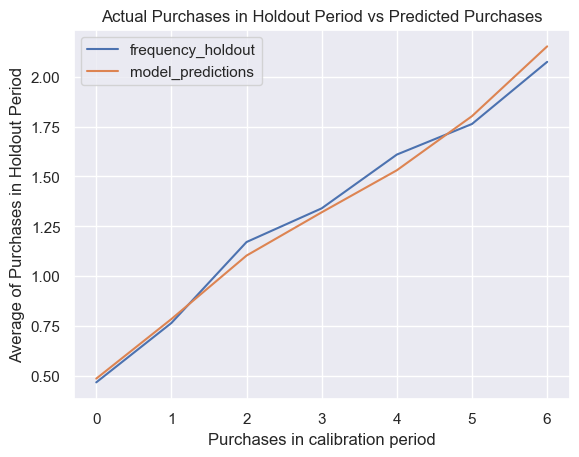

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)

In [ ]:
summary_mbg["actual_30"] = summary_mbg["frequency"]/summary_mbg["recency"]*30

In [ ]:
summary_mbg = summary_mbg.fillna(value = 0)

In [ ]:
summary_mbg.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.0,10.0,400.0,725.0,-15.468000,0.056541,0.750000
1,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388
2,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364
4,12350.0,0.0,0.0,310.0,0.000000,0.055882,0.000000


In [ ]:
summary_mbg["Error"] = summary_mbg["actual_30"] - summary_mbg["predicted_purchases"]

In [ ]:
mse = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])

In [ ]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_mbg["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 4.346082724386108
Average Error:  0.4170902913449528
Root Mean Squared Error: 2.0847260549976605


In [ ]:
mbg_mse_purchase = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
mbg_rmse_purchase = sqrt(mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"]))
mbg_avg_purchase_error = (summary_mbg["actual_30"].mean() - summary_mbg["predicted_purchases"].mean())

In [ ]:
res_summary = summary_mbg[summary_mbg["frequency"] > 0]

In [ ]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

<Axes: >

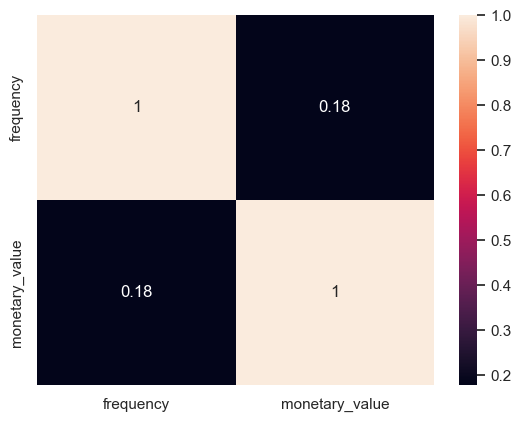

In [ ]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

In [ ]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [ ]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 1.37, q: 3.86, v: 696.90>

In [ ]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.374683,0.058567,1.259892,1.489475
q,3.864415,0.134545,3.600708,4.128123
v,696.904781,50.767856,597.399783,796.409779


In [ ]:
summary_mbg_new = summary_mbg[(summary_mbg["monetary_value"] > 0) & (summary_mbg["frequency"] > 0)]

In [ ]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
1,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089
2,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321
6,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529
7,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512
...,...,...,...,...,...,...,...,...
5935,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776
5936,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890
5937,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759
5940,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480


In [ ]:
summary_mbg_new["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_mbg_new["frequency"], 
                                                                        summary_mbg_new["monetary_value"])

In [ ]:
summary_mbg_new.head()

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
1,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290
2,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995
6,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404
7,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476


In [ ]:
print("Expected Average Sales: %s" % summary_mbg_new["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_mbg_new["monetary_value"].mean())
print("Difference: %s" % (summary_mbg_new["monetary_value"].mean() - summary_mbg_new["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"])))

Expected Average Sales: 340.18897558292775
Actual Average Sales: 330.6608495198251
Difference: -9.528126063102661
Mean Squared Error: 20896.88188078893
Root Mean Squared Error: 144.55753830495638


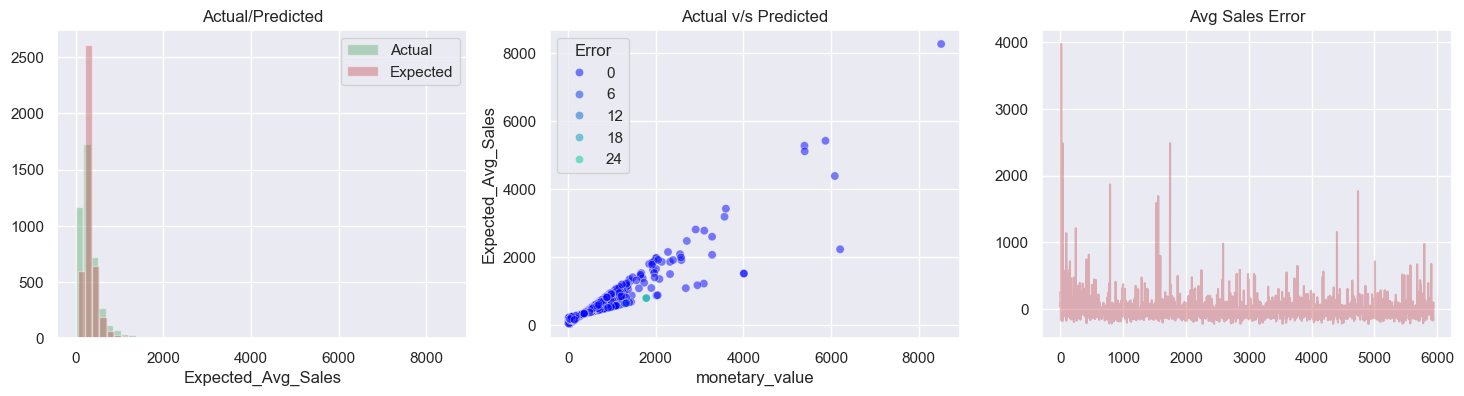

In [ ]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color="g", kde=False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color="r", kde=False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(
    x=summary_mbg_new["monetary_value"],
    y=summary_mbg_new["Expected_Avg_Sales"],
    alpha=0.5,
    hue=summary_mbg_new["Error"],
    palette="winter",
)
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(
    summary_mbg_new["monetary_value"] - summary_mbg_new["Expected_Avg_Sales"],
    color="r",
    alpha=0.4,
)
plt.title("Avg Sales Error")
plt.show()

In [ ]:
summary_mbg_new["predicted_clv"] = ggf.customer_lifetime_value(
    mbg,
    summary_mbg_new["frequency"],
    summary_mbg_new["recency"],
    summary_mbg_new["T"],
    summary_mbg_new["monetary_value"],
    time=30,
    freq="D",
    discount_rate=0.01,
)

In [ ]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
1,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290,7003.290033
2,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301,2522.287420
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995,3504.589499
6,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404,3031.895454
7,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476,585.402211
...,...,...,...,...,...,...,...,...,...,...
5935,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776,252.205811,462.472507
5936,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890,189.361729,1721.587682
5937,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759,165.915956,2985.789802
5940,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480,348.308624,502.273040


In [ ]:
summary_mbg_new["CLV"] = summary_mbg_new["predicted_clv"]*0.05

In [ ]:
actual = summary_["monetary_value"]*summary_["actual_30"]
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]
error = actual - pred
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [ ]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % (mean_squared_error(result["Actual"], result["Predicted"])))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 108.1982810316359
Mean Squared Error: 907287.2534810009
Root Mean Squared Error: 952.5162746541399


In [ ]:
summary_mbg_new

,Customer ID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
1,12347.0,7.0,402.0,404.0,717.398571,0.491299,0.522388,0.031089,629.556290,7003.290033,350.164502
2,12348.0,4.0,363.0,438.0,449.310000,0.263606,0.330579,0.066973,409.972301,2522.287420,126.114371
3,12349.0,4.0,717.0,735.0,1107.172500,0.170685,0.167364,-0.003321,842.513995,3504.589499,175.229475
6,12352.0,8.0,356.0,392.0,218.182500,0.558628,0.674157,0.115529,242.209404,3031.895454,151.594773
7,12353.0,1.0,204.0,408.0,89.000000,0.089547,0.147059,0.057512,254.858476,585.402211,29.270111
...,...,...,...,...,...,...,...,...,...,...,...
5935,18281.0,1.0,397.0,577.0,80.820000,0.069791,0.075567,0.005776,252.205811,462.472507,23.123625
5936,18282.0,2.0,119.0,126.0,38.195000,0.422312,0.504202,0.081890,189.361729,1721.587682,86.079384
5937,18283.0,18.0,655.0,658.0,146.405556,0.778669,0.824427,0.045759,165.915956,2985.789802,149.289490
5940,18286.0,2.0,247.0,723.0,362.740000,0.058435,0.242915,0.184480,348.308624,502.273040,25.113652


In [ ]:
predicted_clv_results = pd.DataFrame(summary_[["Customer ID", "predicted_clv"]])

In [ ]:
predicted_clv_results = predicted_clv_results.merge(summary_copy[["Customer ID", "predicted_clv_p"]], on = "Customer ID")

In [ ]:
predicted_clv_results = predicted_clv_results.merge(summary_mbg_new[["Customer ID", "predicted_clv"]], on = "Customer ID")

In [ ]:
predicted_clv_results.columns = ["Customer ID", "BG-NBD", "Pareto-NBD", "MBG-NBD"]

In [ ]:
predicted_clv_results.head(5)

,Customer ID,BG-NBD,Pareto-NBD,MBG-NBD
0,12347.0,7110.166375,6324.522076,7003.290033
1,12348.0,2512.081673,2199.638346,2522.287420
2,12349.0,3449.798774,3115.671090,3504.589499
3,12352.0,3100.010138,2714.514830,3031.895454
4,12353.0,536.035114,464.556727,585.402211


In [ ]:
#predicted_clv_results.to_csv("Predicted CLV Results.csv")

##### Purchase Prediction Result Summary

In [ ]:
indexes = ["MSE Purchase Error", "RMSE Purchase Error","Avg Purchase Error"]

In [ ]:
data = [
    [bgf_mse_purchase_30, pareto_mse_purchase, mbg_mse_purchase],
    [bgf_rmse_purchase_30, pareto_rmse_purchase, mbg_rmse_purchase],
    [bgf_avg_error_purchase_30, pareto_avg_error_purchase, mbg_avg_purchase_error],
]

In [ ]:
model_purchase_result = pd.DataFrame(data, columns = ["BG-NBD", "Pareto-NBD", "MBG-NBD"], index = indexes)

In [ ]:
model_purchase_result

,BG-NBD,Pareto-NBD,MBG-NBD
MSE Purchase Error,4.337883,4.330122,4.346083
RMSE Purchase Error,2.082758,2.080894,2.084726
Avg Purchase Error,0.411798,0.415448,0.417090


As we can see here is that there is no much difference when it comes to the performance of these models but Pareto NBD model is slightly performing better when it comes it minimizing the MSE & RMSE Errors.